<a href="https://colab.research.google.com/github/jmbavio/Metodos_Analisis_de_Datos_I/blob/main/data_preprocesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Data Preprocessing Techniques - Jupyter Notebook
# Based on José Bavio's presentation "Estrategias de Preprocesamiento de Datos"

# Table of Contents:
# 1. Introduction to Preprocessing
# 2. Strategies for Incomplete and Incorrect Data
# 3. Transformation and Scaling
# 4. Variable Encoding
# 5. Dimensionality Reduction
# 6. Feature Selection
# 7. Handling Imbalanced Data
# 8. Best Practices

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, fetch_california_housing, make_classification
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder,
                                   LabelEncoder, KBinsDiscretizer, PowerTransformer)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor
import umap
from scipy import stats


In [3]:
# Configure visualization settings
# plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('Set2')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


Breast Cancer Dataset (first 5 rows):
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst p

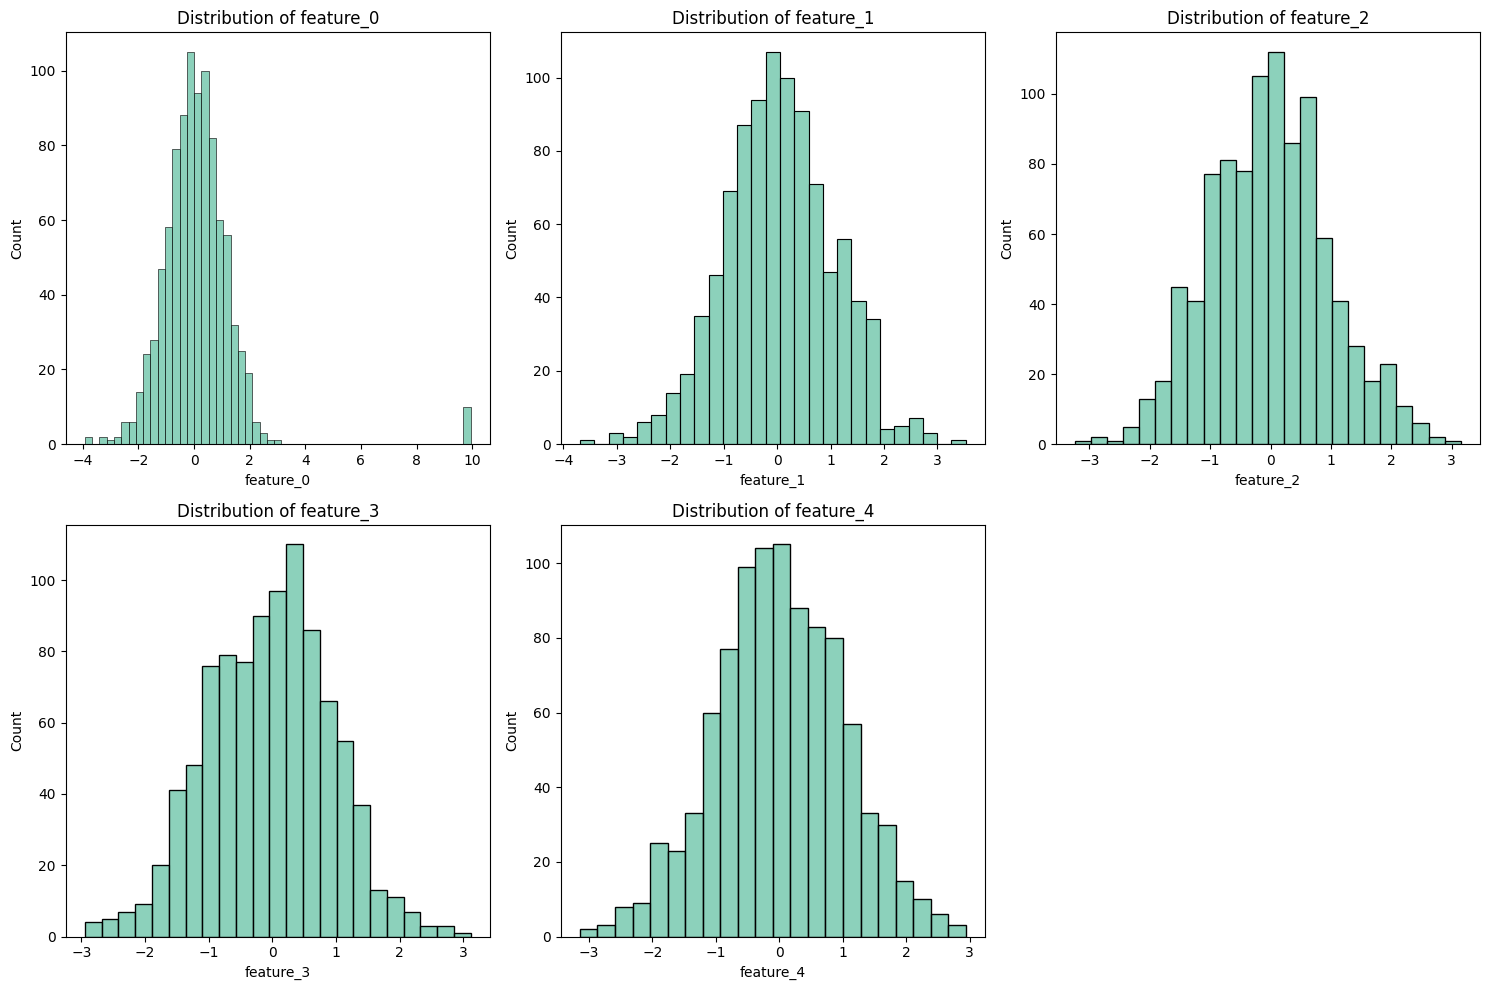

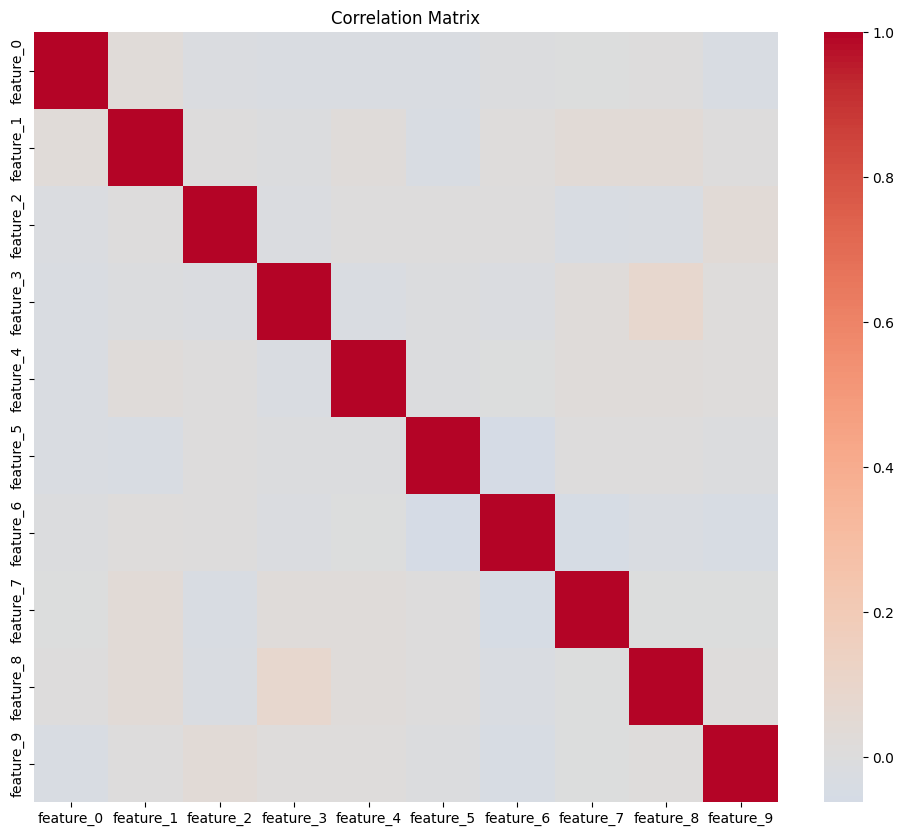

In [4]:
# -------------------------------------------------------------------------
# 1. INTRODUCTION TO PREPROCESSING
# -------------------------------------------------------------------------

# Let's load a real dataset to work with throughout the notebook
breast_cancer = load_breast_cancer()
df_cancer = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df_cancer['target'] = breast_cancer.target

# Let's create a synthetic dataset with various issues for demonstration
np.random.seed(42)
n_samples = 1000
n_features = 10

# Create synthetic feature data
X = np.random.randn(n_samples, n_features)
# Create binary target variable
y = (X[:, 0] + X[:, 1] * 0.5 + np.random.randn(n_samples) * 0.2 > 0).astype(int)

# Create DataFrame
df_synthetic = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df_synthetic['target'] = y

# Add categorical variables
categories = ['A', 'B', 'C', 'D']
df_synthetic['category_1'] = np.random.choice(categories, size=n_samples)
df_synthetic['category_2'] = np.random.choice(['X', 'Y', 'Z'], size=n_samples)

# Add datetime variable
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2025-04-01')
dates = pd.date_range(start=start_date, end=end_date, periods=n_samples)
df_synthetic['date'] = dates

# Introduce missing values (about 5%)
for col in df_synthetic.columns[:5]:
    mask = np.random.random(n_samples) < 0.05
    df_synthetic.loc[mask, col] = np.nan

# Introduce outliers in feature_0 (about 1%)
outlier_idx = np.random.choice(n_samples, size=int(n_samples * 0.01), replace=False)
df_synthetic.loc[outlier_idx, 'feature_0'] = df_synthetic['feature_0'].mean() + df_synthetic['feature_0'].std() * 10

# Let's look at our datasets
print("Breast Cancer Dataset (first 5 rows):")
print(df_cancer.head())
print("\nShape:", df_cancer.shape)
print("\nClass distribution:")
print(df_cancer['target'].value_counts())

print("\n\nSynthetic Dataset (first 5 rows):")
print(df_synthetic.head())
print("\nShape:", df_synthetic.shape)
print("\nClass distribution:")
print(df_synthetic['target'].value_counts())

# Dataset exploration
def explore_dataset(df, title):
    print(f"\n{title} Dataset Summary:")
    print("Shape:", df.shape)
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values (count):")
    print(df.isnull().sum())
    print("\nMissing values (percentage):")
    print((df.isnull().sum() / len(df) * 100).round(2))
    print("\nDescriptive statistics:")
    print(df.describe().T)

    # Visualize distributions of numerical features
    plt.figure(figsize=(15, 10))
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns[:5]  # First 5 numeric columns
    for i, col in enumerate(numeric_cols):
        plt.subplot(2, 3, i+1)
        sns.histplot(df[col])
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(12, 10))
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    if len(numeric_df.columns) > 10:
        numeric_df = numeric_df.iloc[:, :10]  # First 10 numeric columns if there are too many
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()

# Run exploratory data analysis on synthetic dataset
explore_dataset(df_synthetic, "Synthetic")


In [5]:
breast_cancer

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

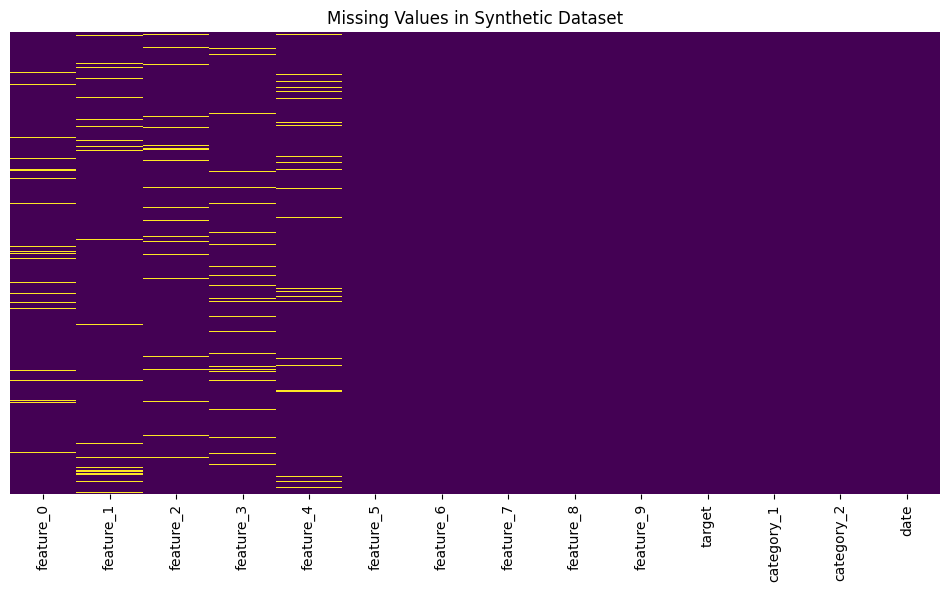

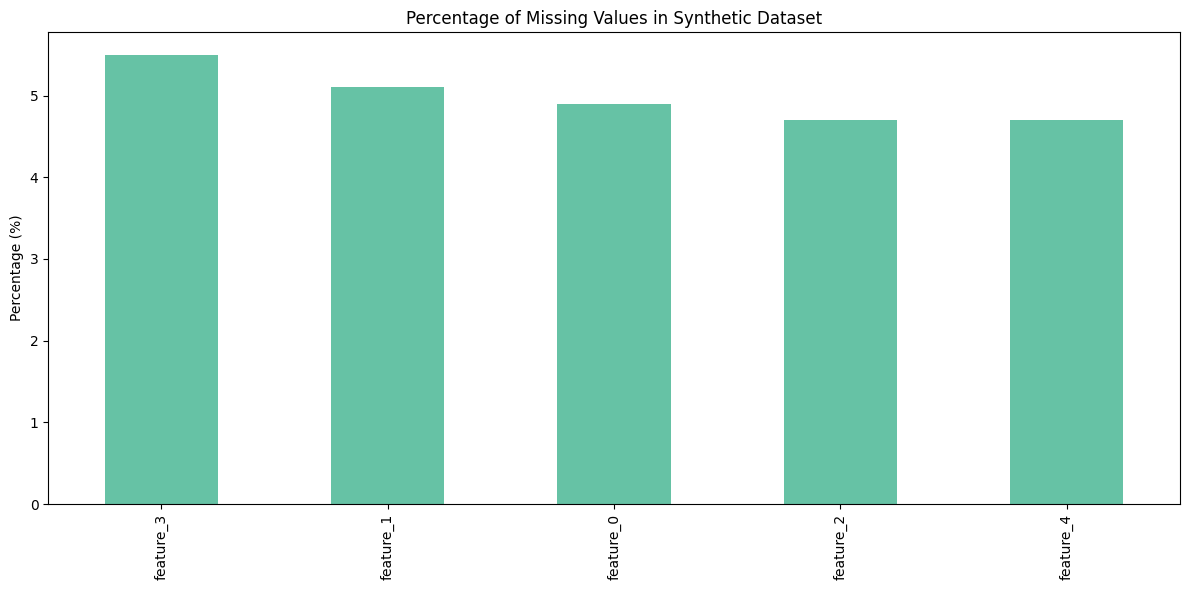

Original shape: (1000, 14)
Shape after dropping rows with NaN: (774, 14)
Columns dropped due to high missing percentage: []
Shape after dropping high-missing columns: (1000, 14)


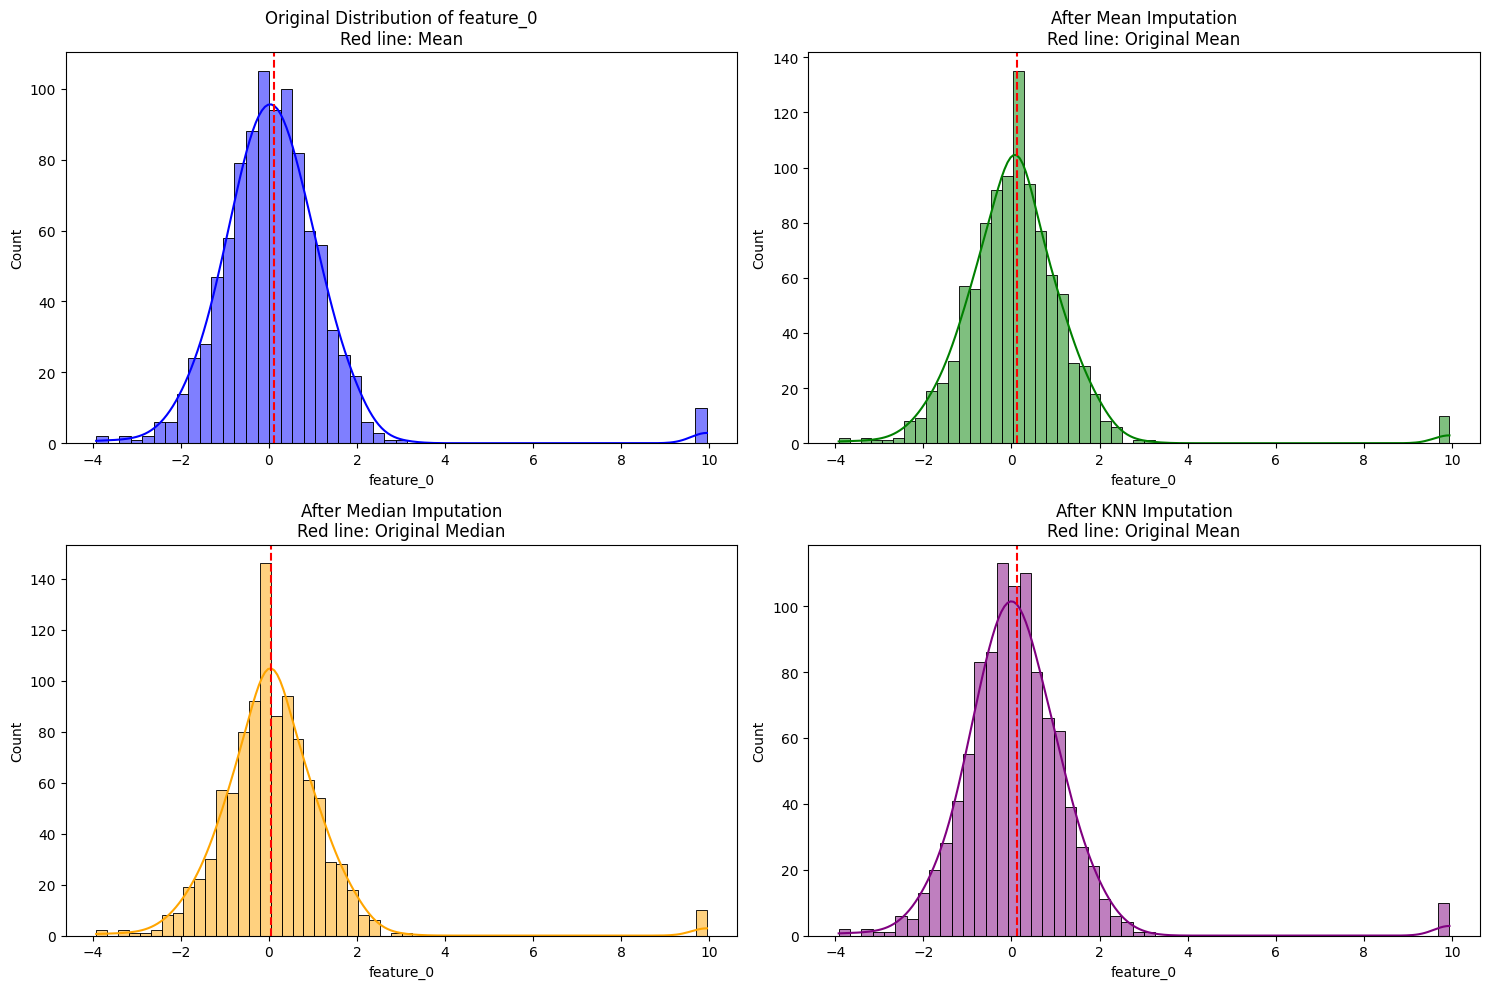

Dataset with missingness indicators:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.496714  -0.138264   0.647689   1.523030  -0.234153  -0.234137   
1  -0.463418  -0.465730   0.241962  -1.913280  -1.724918  -0.562288   
2   1.465649  -0.225776   0.067528  -1.424748  -0.544383   0.110923   
3  -0.601707   1.852278  -0.013497  -1.057711   0.822545  -1.220844   
4   0.738467   0.171368  -0.115648  -0.301104  -1.478522  -0.719844   

   feature_6  feature_7  feature_8  feature_9  target category_1 category_2  \
0   1.579213   0.767435  -0.469474   0.542560       1          C          Z   
1  -1.012831   0.314247  -0.908024  -1.412304       0          B          Z   
2  -1.150994   0.375698  -0.600639  -0.291694       1          B          Y   
3   0.208864  -1.959670  -1.328186   0.196861       1          A          Y   
4  -0.460639   1.057122   0.343618  -1.763040       1          C          X   

                           date  feature_0_missing  feature_1

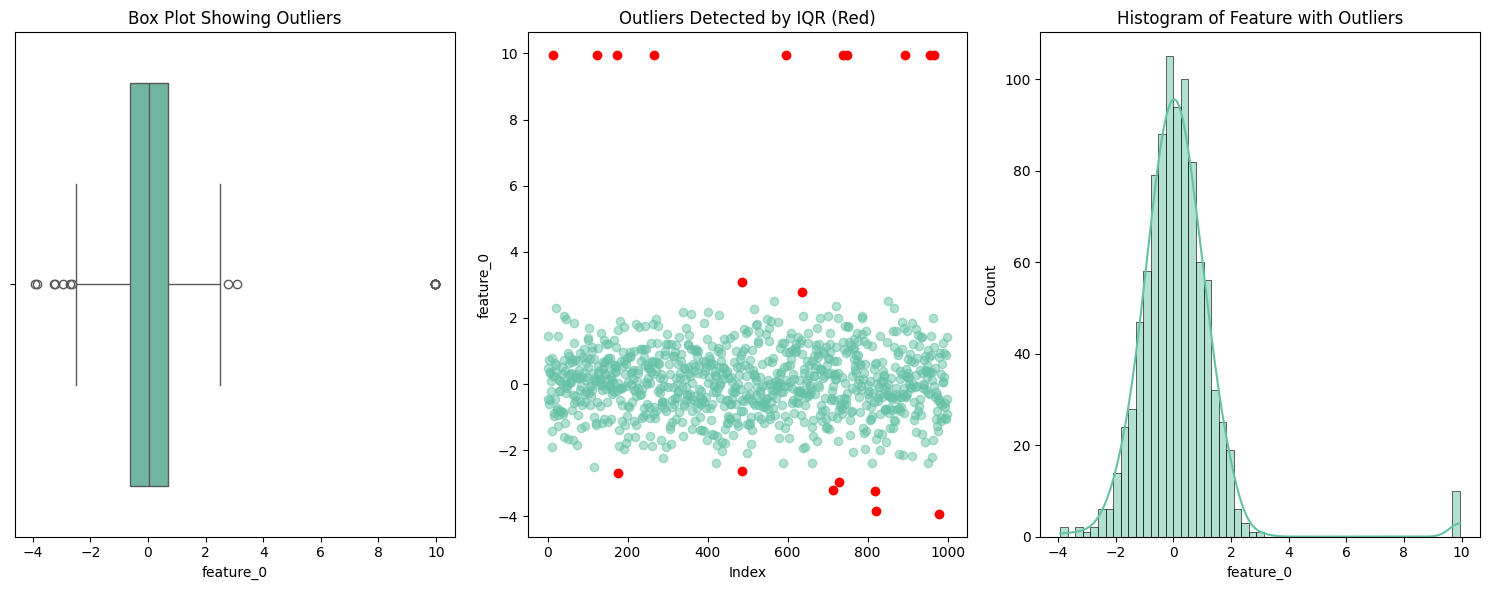

Original DataFrame shape: (1000, 14)
DataFrame shape after removing outliers (IQR): (981, 14)


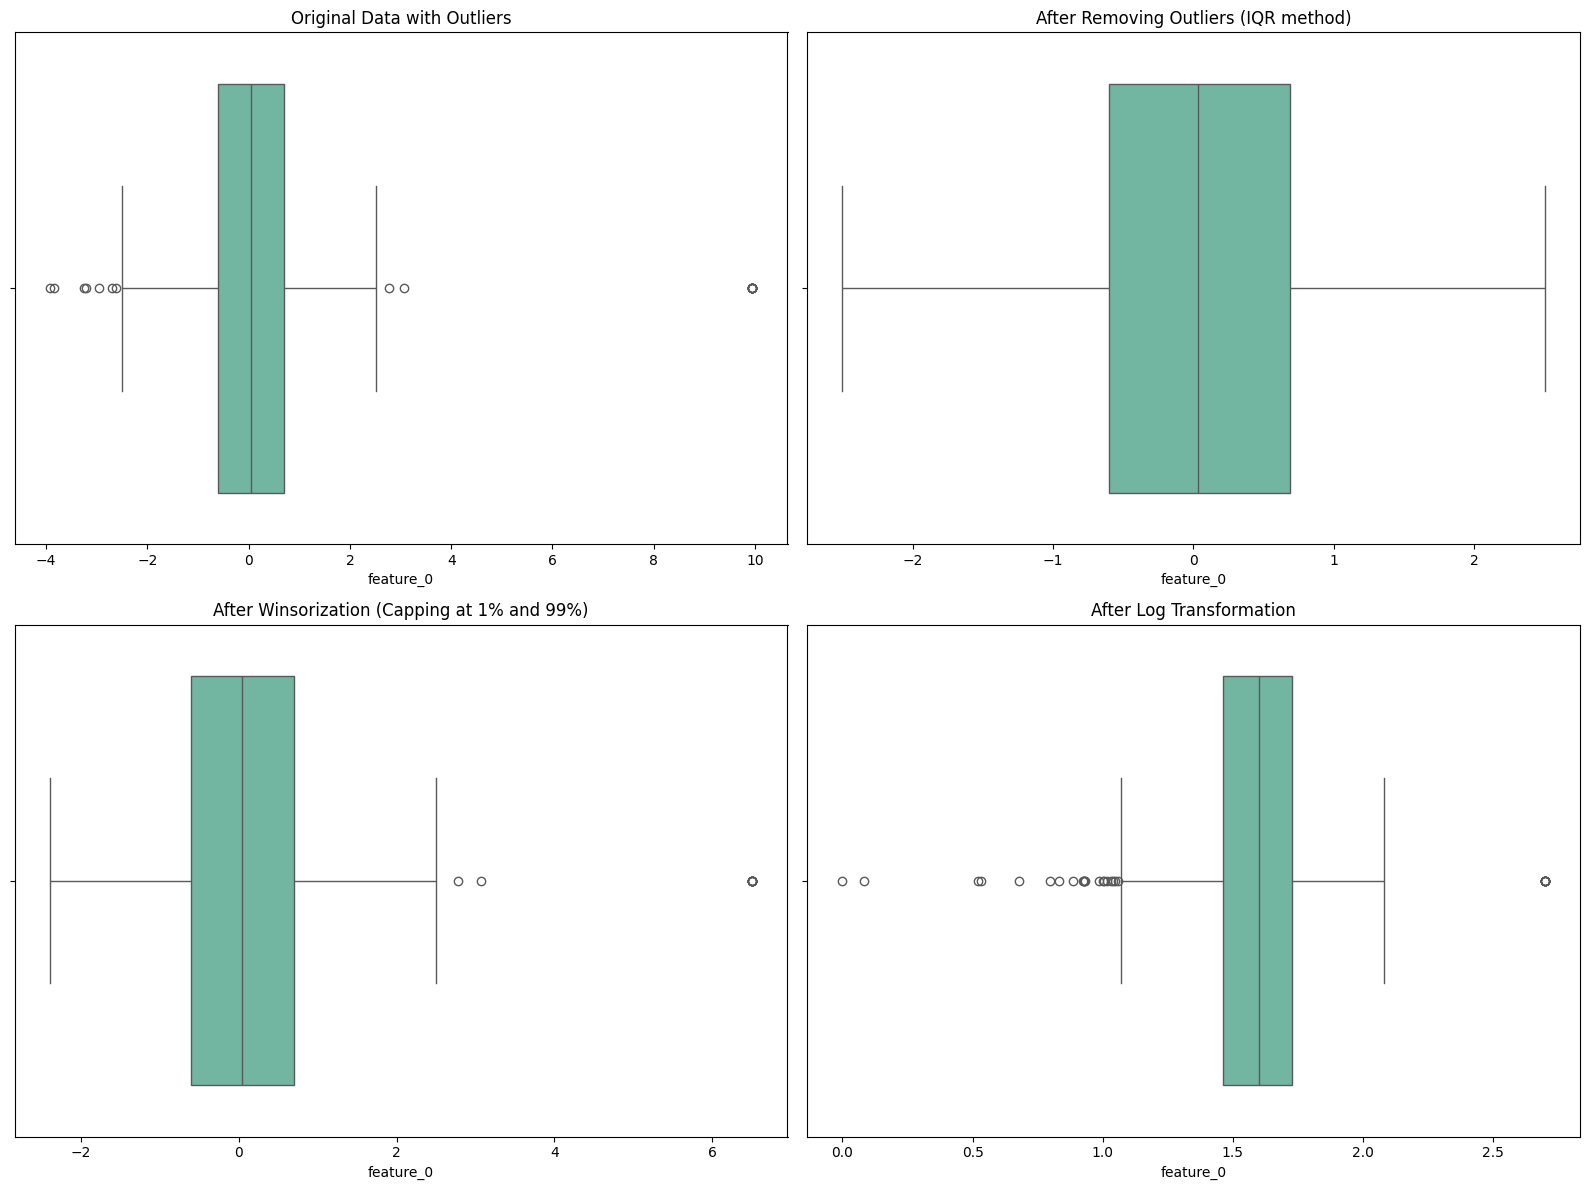

In [6]:

# -------------------------------------------------------------------------
# 2. STRATEGIES FOR INCOMPLETE AND INCORRECT DATA
# -------------------------------------------------------------------------

# 2.1 Detecting and visualizing missing values
def visualize_missing_values(df, title):
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title(f'Missing Values in {title} Dataset')
    plt.show()

    missing_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    missing_percentage = missing_percentage[missing_percentage > 0]

    plt.figure(figsize=(12, 6))
    missing_percentage.plot(kind='bar')
    plt.title(f'Percentage of Missing Values in {title} Dataset')
    plt.ylabel('Percentage (%)')
    plt.tight_layout()
    plt.show()

# Visualize missing values in synthetic dataset
visualize_missing_values(df_synthetic, "Synthetic")

# 2.2 Handling missing values
# Let's create a copy to avoid modifying the original dataset
df_missing = df_synthetic.copy()

# Method 1: Dropping rows with missing values
df_dropped = df_missing.dropna()
print("Original shape:", df_missing.shape)
print("Shape after dropping rows with NaN:", df_dropped.shape)

# Method 2: Dropping columns with high percentage of missing values
threshold = 0.1  # 10% threshold
columns_to_drop = [col for col in df_missing.columns
                   if df_missing[col].isnull().mean() > threshold]
df_dropped_cols = df_missing.drop(columns=columns_to_drop)
print("Columns dropped due to high missing percentage:", columns_to_drop)
print("Shape after dropping high-missing columns:", df_dropped_cols.shape)

# Method 3: Simple imputation (mean, median, mode)
# For numerical values
imputer_mean = SimpleImputer(strategy='mean')
df_missing_numeric = df_missing.select_dtypes(include=['float64', 'int64'])
numeric_cols = df_missing_numeric.columns
df_imputed_mean = pd.DataFrame(
    imputer_mean.fit_transform(df_missing_numeric),
    columns=numeric_cols
)

imputer_median = SimpleImputer(strategy='median')
df_imputed_median = pd.DataFrame(
    imputer_median.fit_transform(df_missing_numeric),
    columns=numeric_cols
)

# For categorical values
imputer_mode = SimpleImputer(strategy='most_frequent')
df_missing_cat = df_missing.select_dtypes(include=['object'])
if not df_missing_cat.empty:  # Check if there are categorical columns
    cat_cols = df_missing_cat.columns
    df_imputed_mode = pd.DataFrame(
        imputer_mode.fit_transform(df_missing_cat),
        columns=cat_cols
    )

# Method 4: Advanced imputation (KNN)
imputer_knn = KNNImputer(n_neighbors=5)
df_imputed_knn = pd.DataFrame(
    imputer_knn.fit_transform(df_missing_numeric),
    columns=numeric_cols
)

# Compare original and imputed values for a column with missing values
missing_col = df_missing_numeric.columns[df_missing_numeric.isnull().any()][0]
original_values = df_missing_numeric[missing_col]
imputed_mean_values = df_imputed_mean[missing_col]
imputed_median_values = df_imputed_median[missing_col]
imputed_knn_values = df_imputed_knn[missing_col]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(original_values.dropna(), kde=True, color='blue')
plt.axvline(original_values.mean(), color='red', linestyle='--')
plt.title(f'Original Distribution of {missing_col}\nRed line: Mean')

plt.subplot(2, 2, 2)
sns.histplot(imputed_mean_values, kde=True, color='green')
plt.axvline(original_values.mean(), color='red', linestyle='--')
plt.title(f'After Mean Imputation\nRed line: Original Mean')

plt.subplot(2, 2, 3)
sns.histplot(imputed_median_values, kde=True, color='orange')
plt.axvline(original_values.median(), color='red', linestyle='--')
plt.title(f'After Median Imputation\nRed line: Original Median')

plt.subplot(2, 2, 4)
sns.histplot(imputed_knn_values, kde=True, color='purple')
plt.axvline(original_values.mean(), color='red', linestyle='--')
plt.title(f'After KNN Imputation\nRed line: Original Mean')

plt.tight_layout()
plt.show()

# Method 5: Creating missingness indicators
df_with_indicators = df_missing.copy()
for col in df_missing_numeric.columns:
    if df_missing[col].isnull().any():
        df_with_indicators[f'{col}_missing'] = df_missing[col].isnull().astype(int)

print("Dataset with missingness indicators:")
print(df_with_indicators.head())

# 2.3 Detecting and handling outliers
# Let's focus on the column where we introduced outliers
column_with_outliers = 'feature_0'

# Method 1: Z-score
z_scores = stats.zscore(df_synthetic[column_with_outliers].dropna())
outliers_z = np.abs(z_scores) > 3
print(f"Number of outliers detected by Z-score (abs(z) > 3): {np.sum(outliers_z)}")

# Method 2: IQR
Q1 = df_synthetic[column_with_outliers].quantile(0.25)
Q3 = df_synthetic[column_with_outliers].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df_synthetic[column_with_outliers] < (Q1 - 1.5 * IQR)) |
                (df_synthetic[column_with_outliers] > (Q3 + 1.5 * IQR)))
print(f"Number of outliers detected by IQR method: {np.sum(outliers_iqr)}")

# Method 3: Local Outlier Factor (density-based)
# First, we need to handle NaN values for LOF
lof_data = df_synthetic[[column_with_outliers]].dropna()
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
outliers_lof = lof.fit_predict(lof_data) == -1
print(f"Number of outliers detected by LOF: {np.sum(outliers_lof)}")

# Visualizing outliers with box plot
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x=df_synthetic[column_with_outliers])
plt.title('Box Plot Showing Outliers')

plt.subplot(1, 3, 2)
plt.scatter(range(len(df_synthetic)), df_synthetic[column_with_outliers], alpha=0.5)
outlier_idx_iqr = np.where(outliers_iqr)[0]
plt.scatter(outlier_idx_iqr, df_synthetic.loc[outlier_idx_iqr, column_with_outliers], color='red')
plt.title('Outliers Detected by IQR (Red)')
plt.xlabel('Index')
plt.ylabel(column_with_outliers)

plt.subplot(1, 3, 3)
sns.histplot(df_synthetic[column_with_outliers], kde=True)
plt.title('Histogram of Feature with Outliers')

plt.tight_layout()
plt.show()

# Methods for handling outliers
# Method 1: Removing outliers
df_no_outliers_iqr = df_synthetic[~outliers_iqr]
print(f"Original DataFrame shape: {df_synthetic.shape}")
print(f"DataFrame shape after removing outliers (IQR): {df_no_outliers_iqr.shape}")

# Method 2: Capping (Winsorization)
df_winsorized = df_synthetic.copy()
low = df_synthetic[column_with_outliers].quantile(0.01)
high = df_synthetic[column_with_outliers].quantile(0.99)
df_winsorized[column_with_outliers] = df_winsorized[column_with_outliers].clip(low, high)

# Method 3: Transform to reduce impact of outliers
df_log_transform = df_synthetic.copy()
# Make sure all values are positive for log transform
if df_synthetic[column_with_outliers].min() <= 0:
    df_log_transform[column_with_outliers] = df_synthetic[column_with_outliers] - df_synthetic[column_with_outliers].min() + 1
# Apply log transform
df_log_transform[column_with_outliers] = np.log(df_log_transform[column_with_outliers])

# Compare original vs. handled outliers
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.boxplot(x=df_synthetic[column_with_outliers])
plt.title('Original Data with Outliers')

plt.subplot(2, 2, 2)
sns.boxplot(x=df_no_outliers_iqr[column_with_outliers])
plt.title('After Removing Outliers (IQR method)')

plt.subplot(2, 2, 3)
sns.boxplot(x=df_winsorized[column_with_outliers])
plt.title('After Winsorization (Capping at 1% and 99%)')

plt.subplot(2, 2, 4)
sns.boxplot(x=df_log_transform[column_with_outliers])
plt.title('After Log Transformation')

plt.tight_layout()
plt.show()


In [ ]:

# -------------------------------------------------------------------------
# 3. TRANSFORMATION AND SCALING
# -------------------------------------------------------------------------

# Create a copy for scaling operations
df_scaling = df_synthetic.copy()

# We'll focus on numerical columns
numeric_cols = df_scaling.select_dtypes(include=['float64', 'int64']).columns
X_numeric = df_scaling[numeric_cols].dropna().values

# 3.1 Min-Max Normalization (values between 0 and 1)
min_max_scaler = MinMaxScaler()
X_min_max = min_max_scaler.fit_transform(X_numeric)

# 3.2 Standardization (Z-score)
standard_scaler = StandardScaler()
X_standardized = standard_scaler.fit_transform(X_numeric)

# 3.3 Robust Scaling (using quartiles, less sensitive to outliers)
robust_scaler = RobustScaler()
X_robust = robust_scaler.fit_transform(X_numeric)

# Visualize the effects of different scaling methods on feature_0
plt.figure(figsize=(16, 12))

# Original data
plt.subplot(2, 2, 1)
sns.histplot(X_numeric[:, 0], kde=True)
plt.title('Original Distribution')
plt.axvline(np.mean(X_numeric[:, 0]), color='red', linestyle='--', label='Mean')
plt.axvline(np.median(X_numeric[:, 0]), color='green', linestyle='--', label='Median')
plt.legend()

# Min-Max scaled
plt.subplot(2, 2, 2)
sns.histplot(X_min_max[:, 0], kde=True)
plt.title('Min-Max Normalized [0,1]')
plt.axvline(np.mean(X_min_max[:, 0]), color='red', linestyle='--', label='Mean')
plt.axvline(np.median(X_min_max[:, 0]), color='green', linestyle='--', label='Median')
plt.legend()

# Standardized
plt.subplot(2, 2, 3)
sns.histplot(X_standardized[:, 0], kde=True)
plt.title('Standardized (Z-score)')
plt.axvline(np.mean(X_standardized[:, 0]), color='red', linestyle='--', label='Mean')
plt.axvline(np.median(X_standardized[:, 0]), color='green', linestyle='--', label='Median')
plt.legend()

# Robust scaled
plt.subplot(2, 2, 4)
sns.histplot(X_robust[:, 0], kde=True)
plt.title('Robust Scaled')
plt.axvline(np.mean(X_robust[:, 0]), color='red', linestyle='--', label='Mean')
plt.axvline(np.median(X_robust[:, 0]), color='green', linestyle='--', label='Median')
plt.legend()

plt.tight_layout()
plt.show()

# 3.4 Non-linear transformations
df_transform = df_synthetic.copy()

# Let's create some skewed data for better visualization
df_transform['exp_feature'] = np.exp(df_transform['feature_0'])
df_transform['square_feature'] = df_transform['feature_1'] ** 2
df_transform['right_skew'] = np.random.exponential(size=len(df_transform))
df_transform['left_skew'] = -np.random.exponential(size=len(df_transform))

# Apply different transformations
df_transform['log_transform'] = np.log1p(df_transform['exp_feature'])  # log(x+1) for non-negative values
df_transform['sqrt_transform'] = np.sqrt(np.abs(df_transform['square_feature']))  # sqrt(|x|) to handle negative values

# Box-Cox transformation requires strictly positive values
power_transformer = PowerTransformer(method='box-cox')
df_transform['boxcox_transform'] = power_transformer.fit_transform(df_transform[['exp_feature']])

# Yeo-Johnson transformation can handle negative values
power_transformer_yj = PowerTransformer(method='yeo-johnson')
df_transform['yeojohnson_transform'] = power_transformer_yj.fit_transform(df_transform[['square_feature']])

# Visualize original and transformed distributions
plt.figure(figsize=(16, 20))

# Original skewed distributions
plt.subplot(4, 2, 1)
sns.histplot(df_transform['exp_feature'], kde=True)
plt.title('Original Exponential Feature (Right Skewed)')

plt.subplot(4, 2, 2)
sns.histplot(df_transform['square_feature'], kde=True)
plt.title('Original Squared Feature')

# Log transformation
plt.subplot(4, 2, 3)
sns.histplot(df_transform['log_transform'], kde=True)
plt.title('After Log Transformation')

# Square root transformation
plt.subplot(4, 2, 4)
sns.histplot(df_transform['sqrt_transform'], kde=True)
plt.title('After Square Root Transformation')

# Box-Cox transformation
plt.subplot(4, 2, 5)
sns.histplot(df_transform['boxcox_transform'], kde=True)
plt.title('After Box-Cox Transformation')

# Yeo-Johnson transformation
plt.subplot(4, 2, 6)
sns.histplot(df_transform['yeojohnson_transform'], kde=True)
plt.title('After Yeo-Johnson Transformation')

# Right and left skew distributions
plt.subplot(4, 2, 7)
sns.histplot(df_transform['right_skew'], kde=True)
plt.title('Right Skewed Distribution (Exponential)')

plt.subplot(4, 2, 8)
sns.histplot(df_transform['left_skew'], kde=True)
plt.title('Left Skewed Distribution (Negative Exponential)')

plt.tight_layout()
plt.show()

# 3.5 Discretization and Binning
df_binning = df_synthetic.copy()

# Select a feature to discretize
feature_to_bin = 'feature_0'

# Method 1: Equal-width binning
n_bins = 5
df_binning['equal_width'] = pd.cut(df_binning[feature_to_bin], bins=n_bins, labels=False)

# Method 2: Equal-frequency binning
df_binning['equal_freq'] = pd.qcut(df_binning[feature_to_bin], q=n_bins, labels=False)

# Method 3: K-means binning
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
df_binning['kmeans_binning'] = discretizer.fit_transform(df_binning[[feature_to_bin]])

# Method 4: Custom binning based on domain knowledge
custom_bins = [-np.inf, -2, -1, 0, 1, 2, np.inf]  # Custom bin edges
custom_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extreme']
df_binning['custom_bins'] = pd.cut(df_binning[feature_to_bin], bins=custom_bins, labels=custom_labels)

# Visualize the different binning strategies
plt.figure(figsize=(16, 15))

# Original distribution
plt.subplot(3, 2, 1)
sns.histplot(df_binning[feature_to_bin], kde=True, bins=30)
plt.title('Original Distribution')

# Equal-width binning
plt.subplot(3, 2, 2)
sns.countplot(x='equal_width', data=df_binning)
plt.title('Equal-Width Binning')
plt.xlabel('Bin')

# Equal-frequency binning
plt.subplot(3, 2, 3)
sns.countplot(x='equal_freq', data=df_binning)
plt.title('Equal-Frequency Binning')
plt.xlabel('Bin')

# K-means binning
plt.subplot(3, 2, 4)
sns.countplot(x='kmeans_binning', data=df_binning)
plt.title('K-means Binning')
plt.xlabel('Bin')

# Custom binning
plt.subplot(3, 2, 5)
sns.countplot(x='custom_bins', data=df_binning)
plt.title('Custom Binning')
plt.xlabel('Bin')
plt.xticks(rotation=45)

# Scatter plot showing binning boundaries
plt.subplot(3, 2, 6)
plt.scatter(range(len(df_binning)), df_binning[feature_to_bin], alpha=0.5)
for edge in custom_bins[1:-1]:  # Skip -inf and inf
    plt.axhline(edge, color='red', linestyle='--')
plt.title('Custom Binning Boundaries')
plt.xlabel('Index')
plt.ylabel(feature_to_bin)

plt.tight_layout()
plt.show()

# Impact of binning on a simple model
# Let's create a classification problem using the binned feature
X = df_binning[['equal_width', 'equal_freq', 'kmeans_binning']].values
y = df_binning['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a decision tree
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using binned features: {accuracy:.4f}")


In [ ]:
# ------------------------------------------------------------------------
# 4. VARIABLE ENCODING
# -------------------------------------------------------------------------

# Create a copy for encoding operations
df_encoding = df_synthetic.copy()

# 4.1 Label Encoding
label_encoder = LabelEncoder()
df_encoding['category_1_label'] = label_encoder.fit_transform(df_encoding['category_1'])
df_encoding['category_2_label'] = label_encoder.fit_transform(df_encoding['category_2'])

print("Label Encoding Results:")
print(pd.crosstab(df_encoding['category_1'], df_encoding['category_1_label']))
print("\n")
print(pd.crosstab(df_encoding['category_2'], df_encoding['category_2_label']))

# 4.2 One-Hot Encoding
# Using pandas get_dummies
df_onehot = pd.get_dummies(df_encoding[['category_1', 'category_2']], drop_first=False)
print("\nOne-Hot Encoding (first 5 rows):")
print(df_onehot.head())

# Using scikit-learn
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(df_encoding[['category_1', 'category_2']])
onehot_cols = onehot_encoder.get_feature_names_out(['category_1', 'category_2'])
df_onehot_sklearn = pd.DataFrame(onehot_encoded, columns=onehot_cols)
print("\nOne-Hot Encoding with sklearn (first 5 rows):")
print(df_onehot_sklearn.head())

# 4.3 Binary Encoding
# For binary encoding, we'll use a simple custom implementation
def binary_encode(category_series):
    # Get unique categories
    categories = category_series.unique()
    # Create mappings
    cat_to_int = {cat: i for i, cat in enumerate(categories)}
    # Convert to integers
    int_encoded = category_series.map(cat_to_int)

    # Convert to binary representation
    max_bits = int(np.ceil(np.log2(len(categories))))
    binary_encoded = np.zeros((len(category_series), max_bits), dtype=int)

    for i, val in enumerate(int_encoded):
        binary = format(val, f'0{max_bits}b')
        for j, bit in enumerate(binary):
            binary_encoded[i, j] = int(bit)

    return binary_encoded, [f"{category_series.name}_bit{i}" for i in range(max_bits)]

# Apply binary encoding to category_1
binary_encoded, binary_cols = binary_encode(df_encoding['category_1'])
df_binary = pd.DataFrame(binary_encoded, columns=binary_cols)
print("\nBinary Encoding (first 5 rows):")
print(df_binary.head())

# 4.4 Target Encoding
# Target encoding for categorical variables based on target mean
def target_encode(df, categorical_col, target_col, k=5):
    # Calculate global mean
    global_mean = df[target_col].mean()

    # Group by the categorical column and calculate means
    means = df.groupby(categorical_col)[target_col].agg(['mean', 'count'])

    # Apply smoothing (Bayesian average)
    smoothed_means = (means['mean'] * means['count'] + global_mean * k) / (means['count'] + k)

    # Map back to the original dataframe
    encoded_values = df[categorical_col].map(smoothed_means)

    return encoded_values

# Apply target encoding
df_encoding['category_1_target'] = target_encode(df_encoding, 'category_1', 'target')
df_encoding['category_2_target'] = target_encode(df_encoding, 'category_2', 'target')

print("\nTarget Encoding Results:")
print(pd.DataFrame({
    'Category': df_encoding['category_1'].unique(),
    'Target Mean': [df_encoding.loc[df_encoding['category_1'] == cat, 'target'].mean() for cat in df_encoding['category_1'].unique()],
    'Target Encoding': [df_encoding.loc[df_encoding['category_1'] == cat, 'category_1_target'].mean() for cat in df_encoding['category_1'].unique()]
}))

# 4.5 Feature Hashing (simplified version)
def feature_hash(df, col, n_features=4):
    # Simple hash function
    hash_values = np.zeros((len(df), n_features))
    for i, val in enumerate(df[col]):
        # Use Python's hash function & modulo to map to feature space
        hash_idx = hash(str(val)) % n_features
        hash_values[i, hash_idx] = 1

    return hash_values, [f"{col}_hash{i}" for i in range(n_features)]

# Apply feature hashing
hash_encoded, hash_cols = feature_hash(df_encoding, 'category_1')
df_hash = pd.DataFrame(hash_encoded, columns=hash_cols)
print("\nFeature Hashing (first 5 rows):")
print(df_hash.head())

# Comparing encoding strategies on a simple classification task
encodings = {
    'Label Encoding': df_encoding[['category_1_label', 'category_2_label']],
    'One-Hot Encoding': df_onehot,
    'Binary Encoding': df_binary,
    'Target Encoding': df_encoding[['category_1_target', 'category_2_target']],
    'Feature Hashing': df_hash
}

# Evaluate each encoding method
results = {}

for name, encoded_df in encodings.items():
    # Prepare data
    X = encoded_df.values
    y = df_encoding['target'].values

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a simple model
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

# Display results
print("\nEncoding Method Comparison (Accuracy):")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# Visualize comparison
plt.figure(figsize=(12, 6))
plt.bar(results.keys(), results.values())
plt.title('Encoding Method Comparison (Classification Accuracy)')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])  # Set y-axis to start from 0.5 for better visibility
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:



# -------------------------------------------------------------------------
# 5. DIMENSIONALITY REDUCTION
# -------------------------------------------------------------------------

# Let's use the breast cancer dataset for dimensionality reduction
X_cancer = df_cancer.drop('target', axis=1).values
y_cancer = df_cancer['target'].values

# 5.1 PCA (Principal Component Analysis)
# Standardize data first (important for PCA)
X_cancer_scaled = StandardScaler().fit_transform(X_cancer)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_cancer_scaled)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.title('Explained Variance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Explained Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()

# Determine optimal number of components
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components for 90% variance: {n_components_90}")
print(f"Number of components for 95% variance: {n_components_95}")

# Visualize data in 2D using first two principal components
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_cancer, cmap='viridis', alpha=0.8)
plt.title('Breast Cancer Data - First 2 Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Target')
plt.show()

# 5.2 t-SNE for visualization
# t-SNE is computationally expensive, so we'll use a subset
np.random.seed(42)
subset_indices = np.random.choice(len(X_cancer_scaled), 500, replace=False)
X_subset = X_cancer_scaled[subset_indices]
y_subset = y_cancer[subset_indices]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_subset)

# Visualize t-SNE results
plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='viridis', alpha=0.8)
plt.title('t-SNE Visualization of Breast Cancer Data')
plt.colorbar(label='Target')
plt.show()

# 5.3 UMAP for visualization
# Install umap-learn if not already installed
# !pip install umap-learn

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_subset)

# Visualize UMAP results
plt.figure(figsize=(12, 10))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_subset, cmap='viridis', alpha=0.8)
plt.title('UMAP Visualization of Breast Cancer Data')
plt.colorbar(label='Target')
plt.show()

# 5.4 Compare t-SNE and UMAP with different parameters
# Experiment with different perplexity values for t-SNE
perplexities = [5, 30, 50]
fig, axes = plt.subplots(1, len(perplexities), figsize=(18, 6))

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_subset)

    axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='viridis', alpha=0.8)
    axes[i].set_title(f't-SNE with Perplexity={perplexity}')
    axes[i].set_xlabel('t-SNE 1')
    axes[i].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

# Experiment with different n_neighbors values for UMAP
n_neighbors_values = [5, 15, 30]
fig, axes = plt.subplots(1, len(n_neighbors_values), figsize=(18, 6))

for i, n_neighbors in enumerate(n_neighbors_values):
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=n_neighbors)
    X_umap = reducer.fit_transform(X_subset)

    axes[i].scatter(X_umap[:, 0], X_umap[:, 1], c=y_subset, cmap='viridis', alpha=0.8)
    axes[i].set_title(f'UMAP with n_neighbors={n_neighbors}')
    axes[i].set_xlabel('UMAP 1')
    axes[i].set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()


Libraries imported successfully!
Breast Cancer Dataset (first 5 rows):
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimen

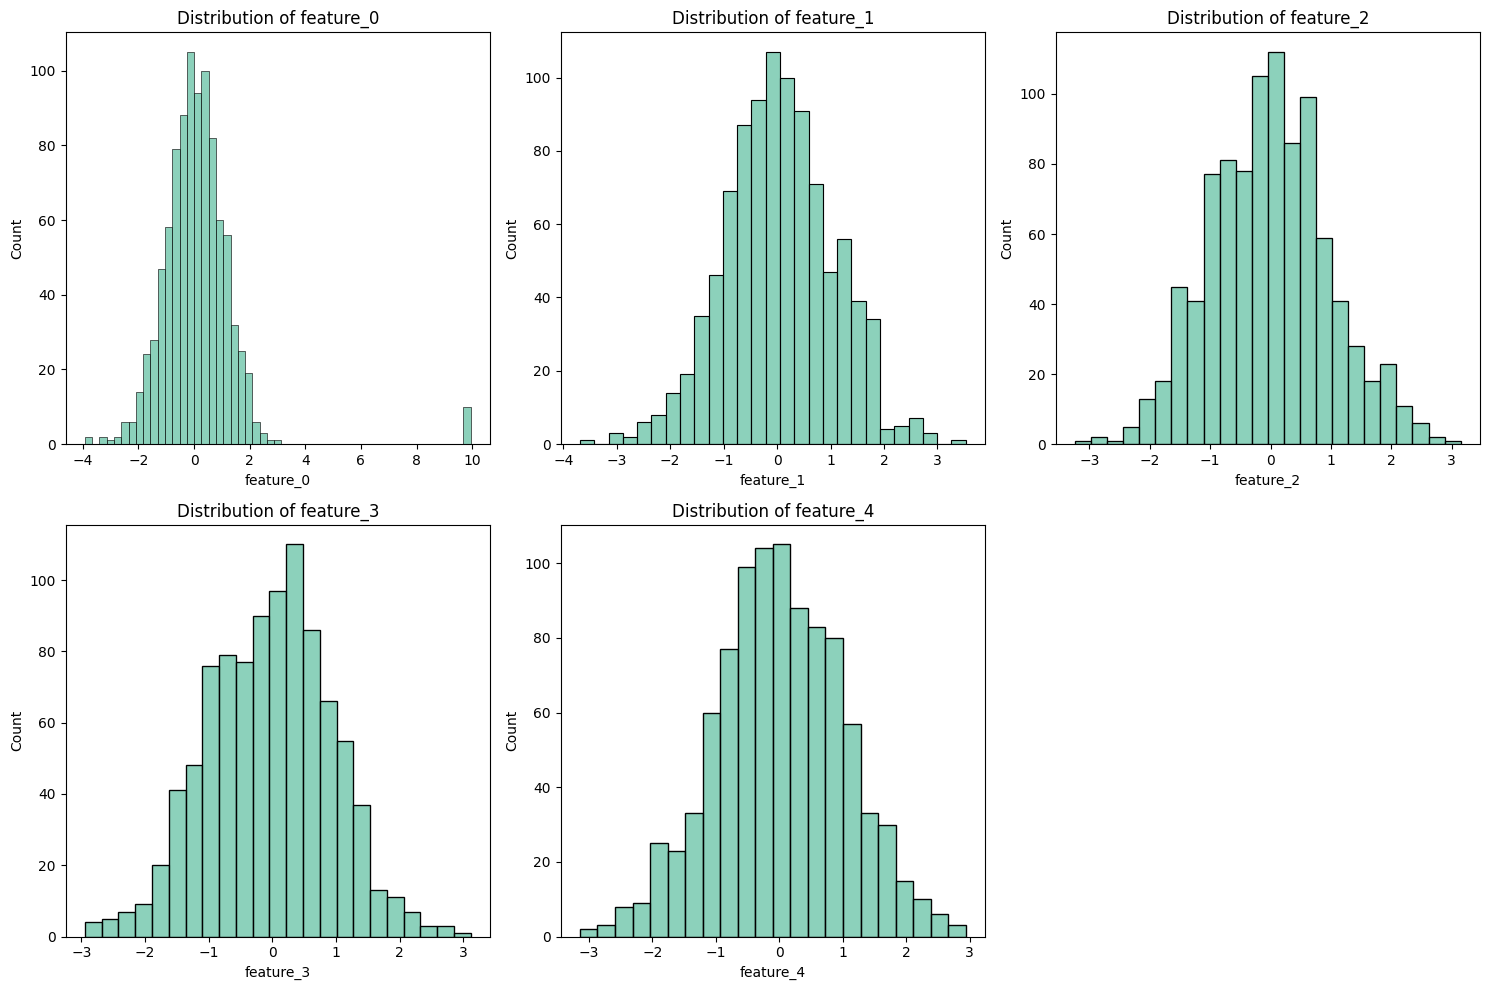

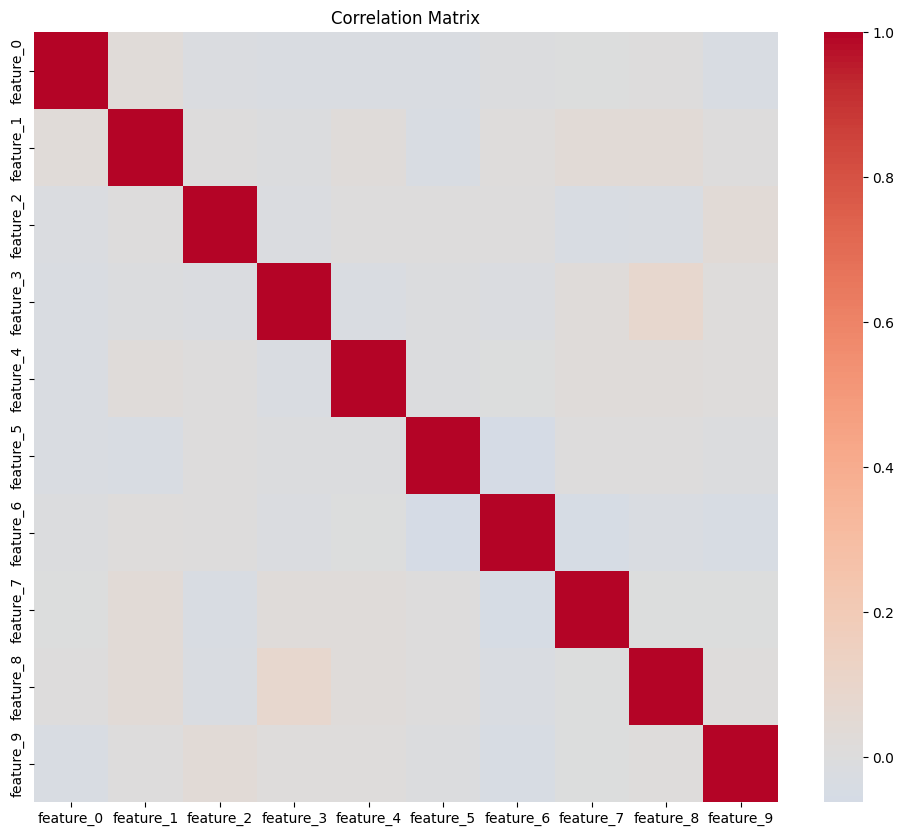

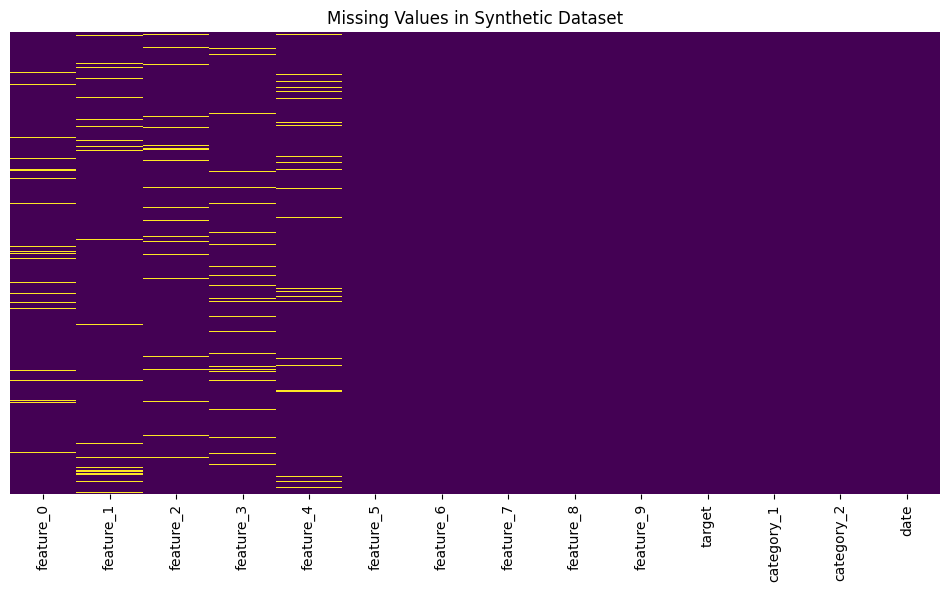

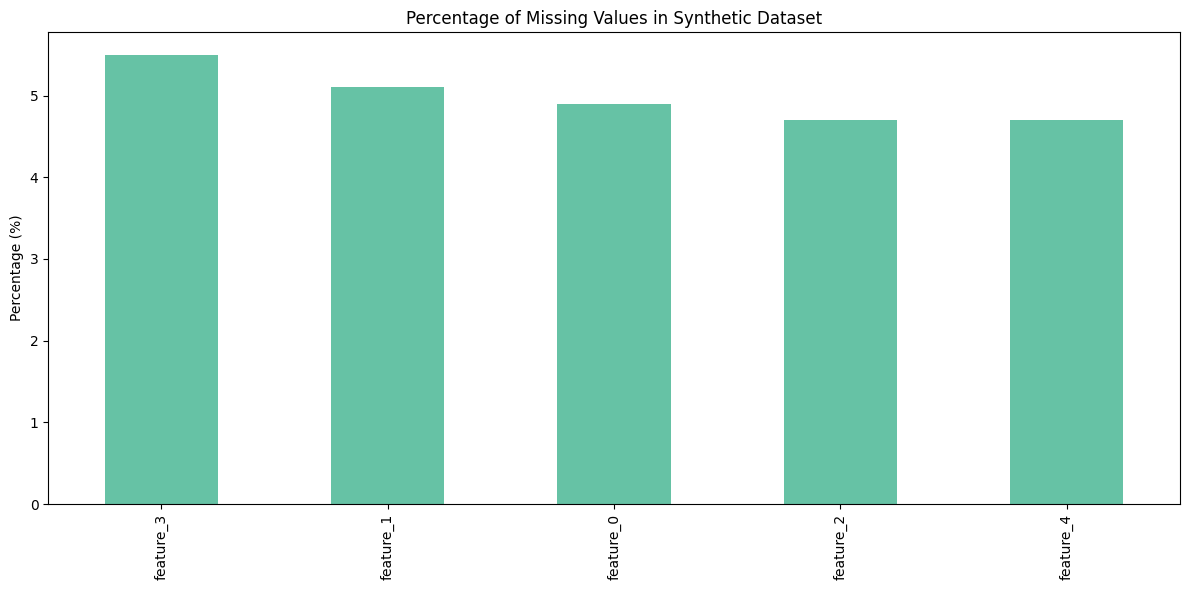

Original shape: (1000, 14)
Shape after dropping rows with NaN: (774, 14)
Columns dropped due to high missing percentage: []
Shape after dropping high-missing columns: (1000, 14)


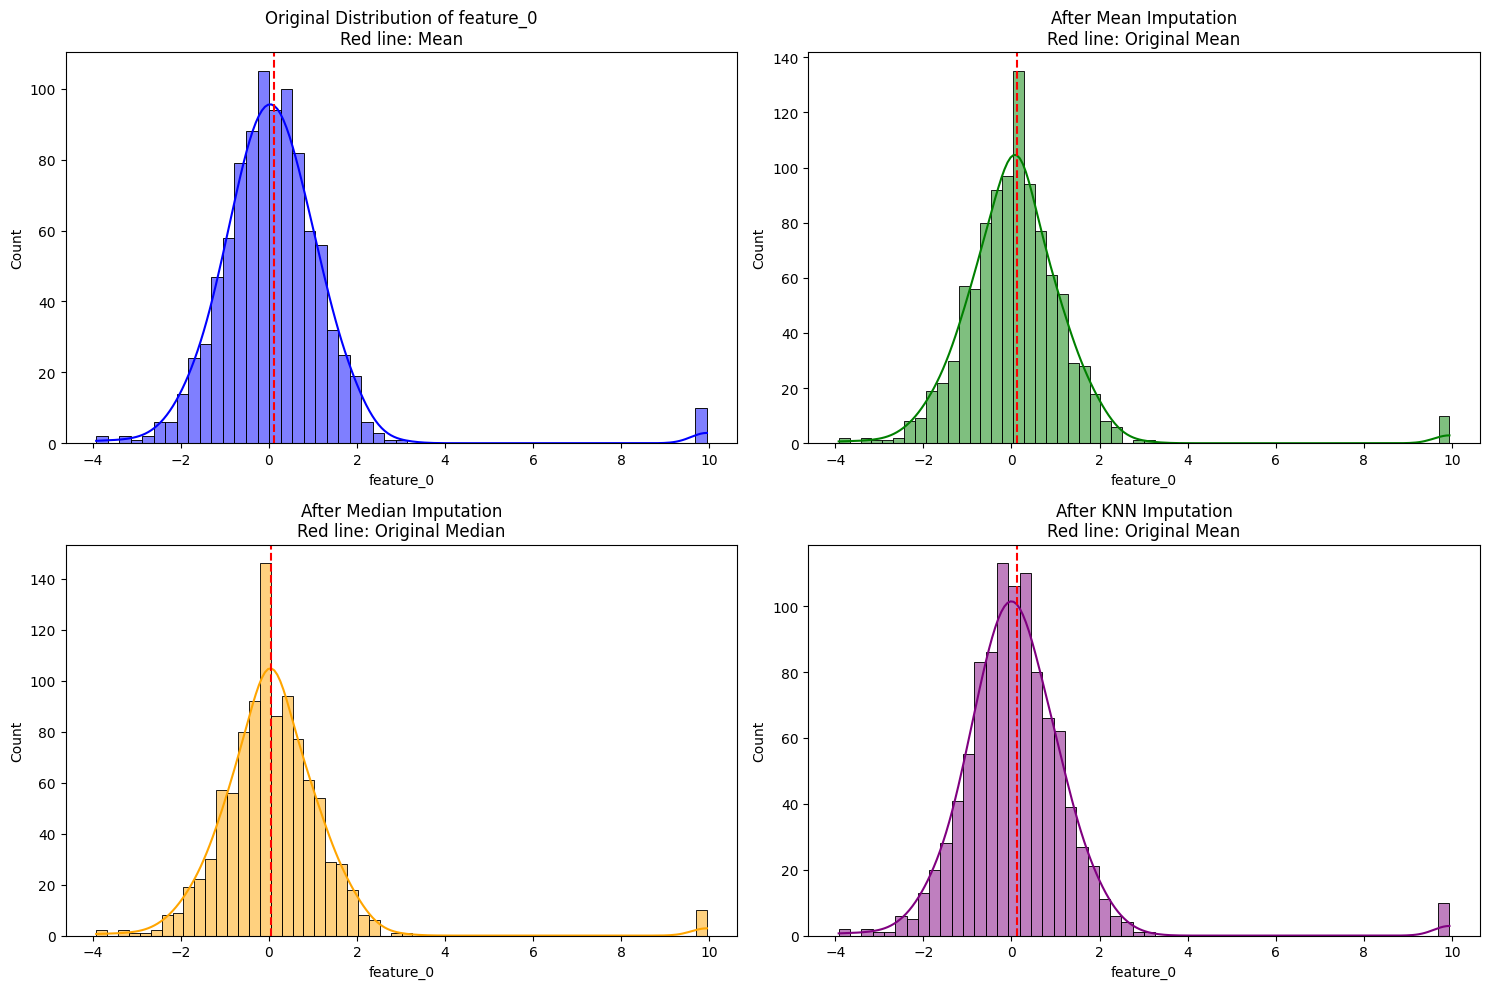

Dataset with missingness indicators:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.496714  -0.138264   0.647689   1.523030  -0.234153  -0.234137   
1  -0.463418  -0.465730   0.241962  -1.913280  -1.724918  -0.562288   
2   1.465649  -0.225776   0.067528  -1.424748  -0.544383   0.110923   
3  -0.601707   1.852278  -0.013497  -1.057711   0.822545  -1.220844   
4   0.738467   0.171368  -0.115648  -0.301104  -1.478522  -0.719844   

   feature_6  feature_7  feature_8  feature_9  target category_1 category_2  \
0   1.579213   0.767435  -0.469474   0.542560       1          C          Z   
1  -1.012831   0.314247  -0.908024  -1.412304       0          B          Z   
2  -1.150994   0.375698  -0.600639  -0.291694       1          B          Y   
3   0.208864  -1.959670  -1.328186   0.196861       1          A          Y   
4  -0.460639   1.057122   0.343618  -1.763040       1          C          X   

                           date  feature_0_missing  feature_1

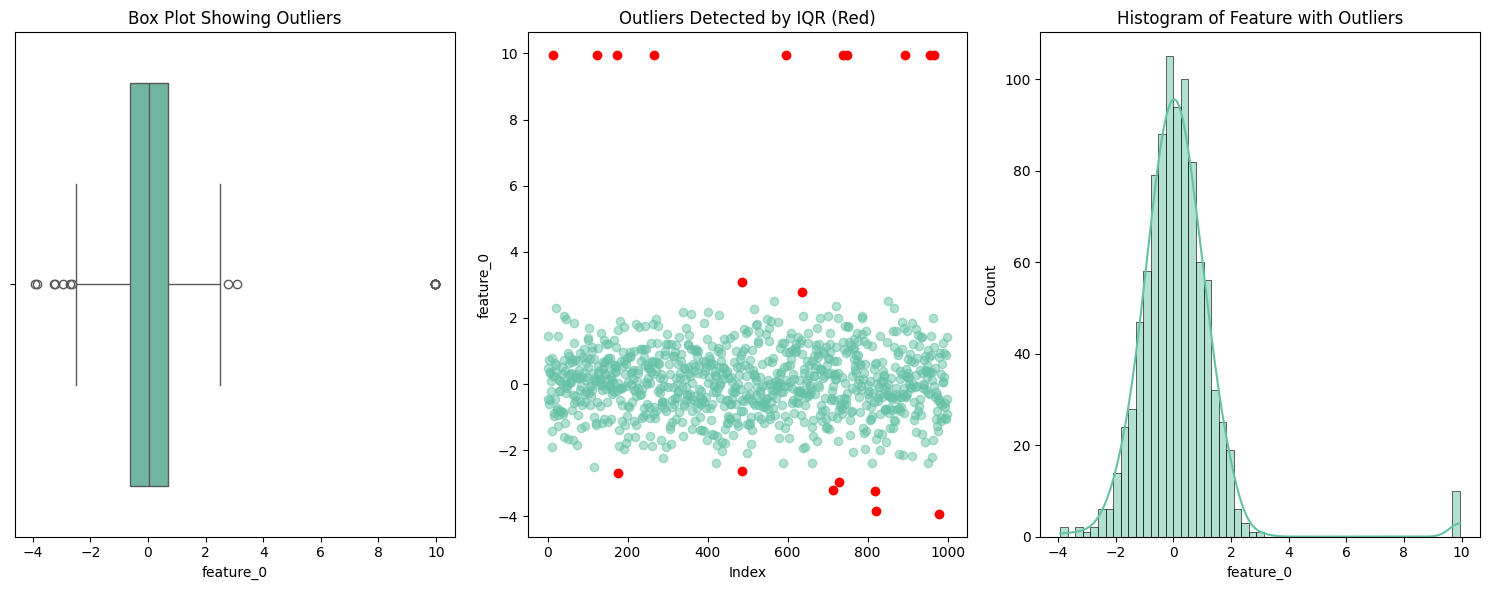

Original DataFrame shape: (1000, 14)
DataFrame shape after removing outliers (IQR): (981, 14)


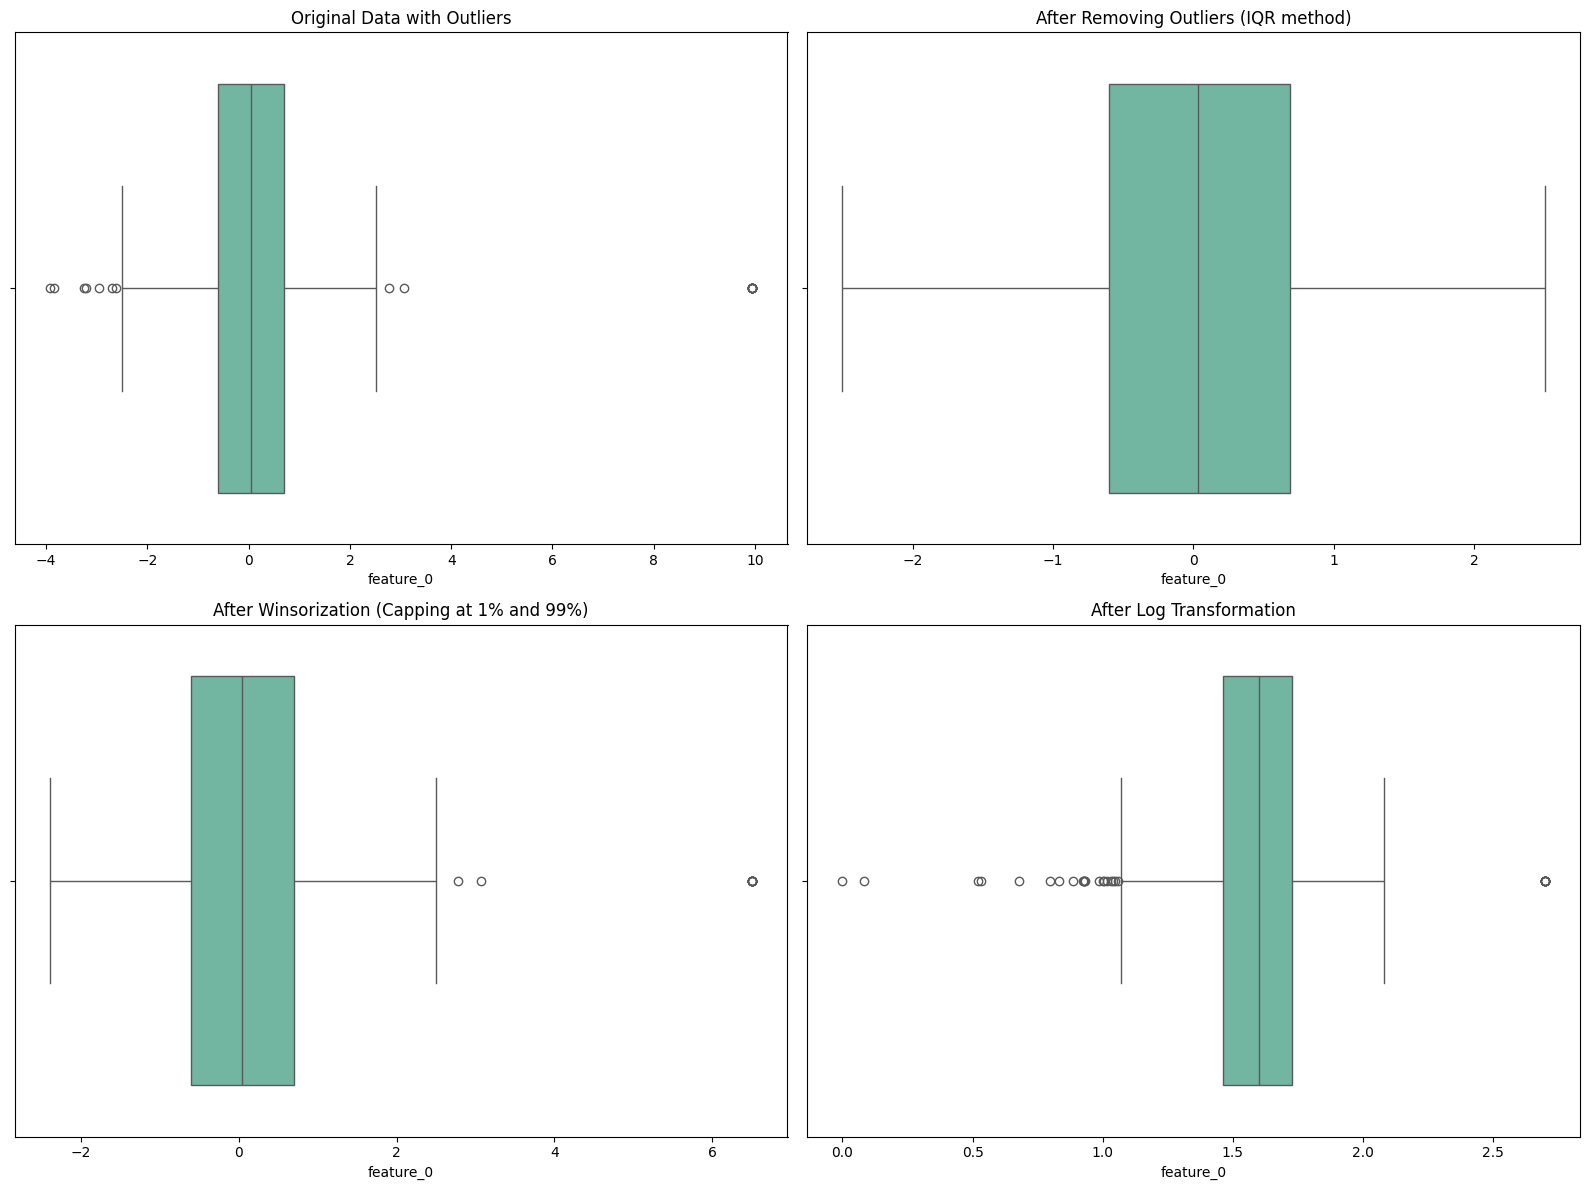

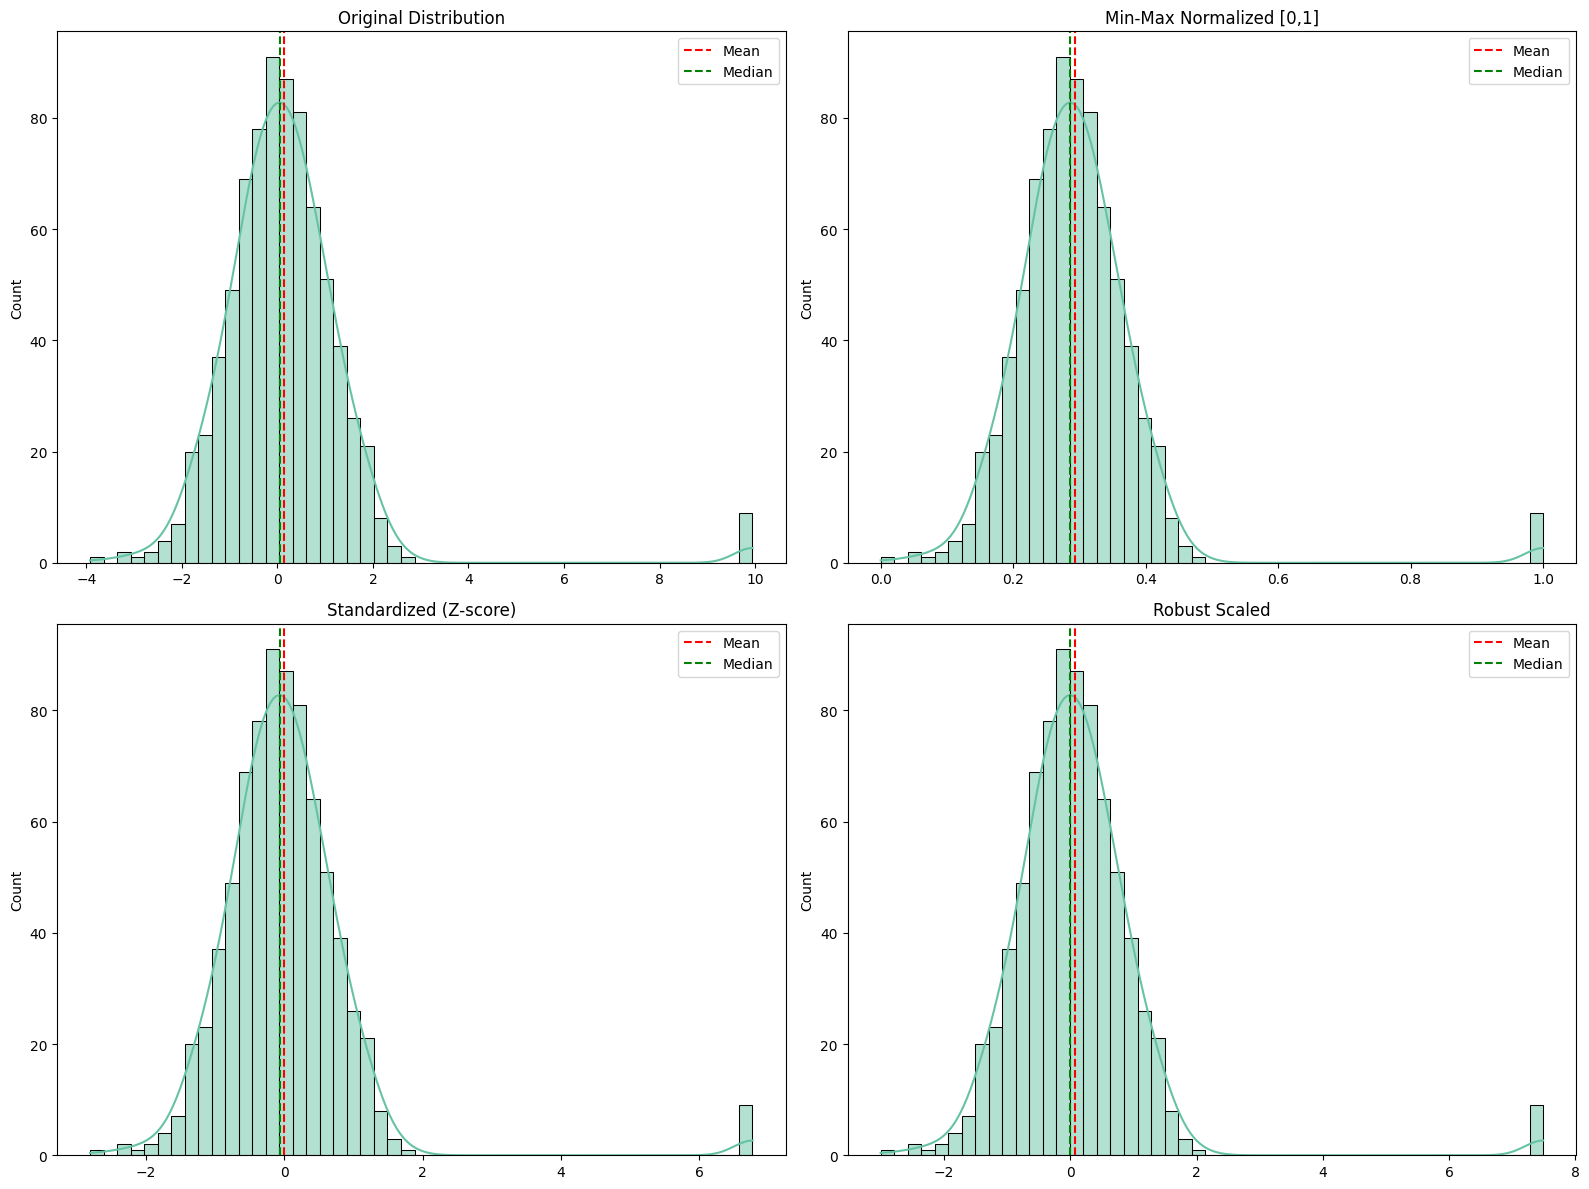

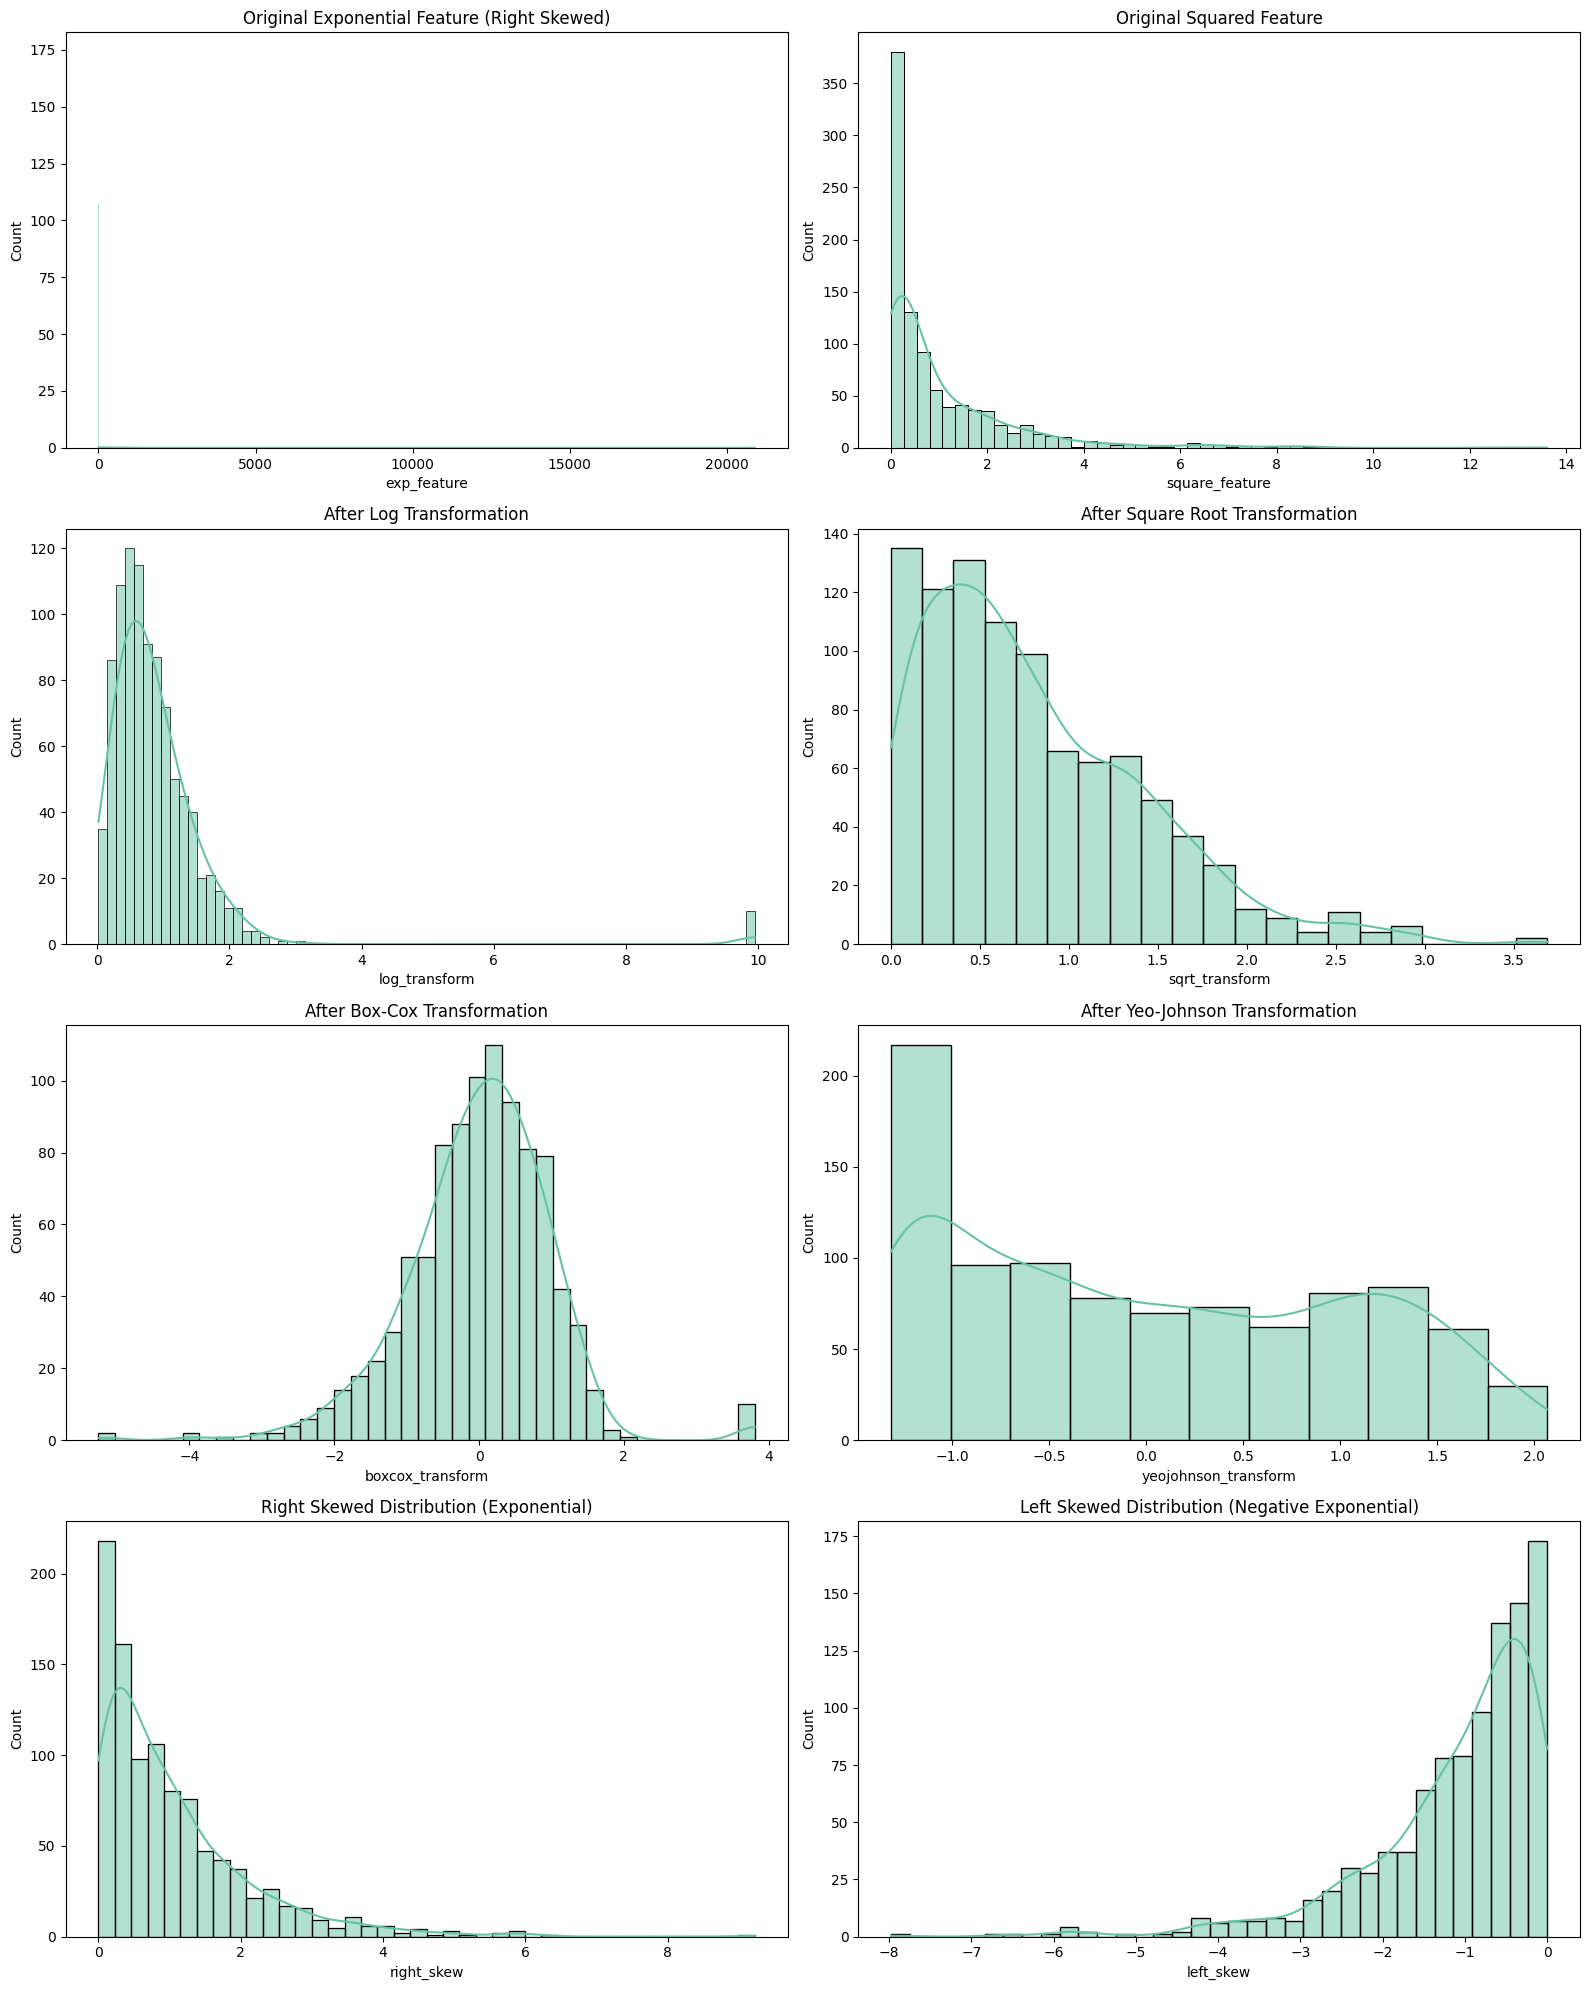

ValueError: Input X contains NaN.
KBinsDiscretizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [1]:

# -------------------------------------------------------------------------
# 6. FEATURE SELECTION
# -------------------------------------------------------------------------

# Let's work with the breast cancer dataset
X = df_cancer.drop('target', axis=1).values
y = df_cancer['target'].values
feature_names = df_cancer.drop('target', axis=1).columns

# 6.1 Filter Methods

# Univariate selection with ANOVA F-test
k_best = 10  # Select top 10 features
selector = SelectKBest(score_func=f_classif, k=k_best)
X_kbest = selector.fit_transform(X, y)

# Get scores and p-values
scores = selector.scores_
pvalues = selector.pvalues_

# Create DataFrame to display results
feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'F-Score': scores,
    'P-Value': pvalues
})
feature_scores = feature_scores.sort_values('F-Score', ascending=False)

print("Top 10 features based on ANOVA F-test:")
print(feature_scores.head(10))

# Visualize F-scores
plt.figure(figsize=(14, 6))
plt.bar(feature_scores['Feature'].head(15), feature_scores['F-Score'].head(15))
plt.title('Feature Importance (ANOVA F-test)')
plt.xticks(rotation=90)
plt.ylabel('F-Score')
plt.tight_layout()
plt.show()

# Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k_best)
X_mi = selector_mi.fit_transform(X, y)

# Get mutual information scores
mi_scores = selector_mi.scores_

# Create DataFrame to display results
feature_mi_scores = pd.DataFrame({
    'Feature': feature_names,
    'Mutual Information': mi_scores
})
feature_mi_scores = feature_mi_scores.sort_values('Mutual Information', ascending=False)

print("\nTop 10 features based on Mutual Information:")
print(feature_mi_scores.head(10))

# Visualize Mutual Information scores
plt.figure(figsize=(14, 6))
plt.bar(feature_mi_scores['Feature'].head(15), feature_mi_scores['Mutual Information'].head(15))
plt.title('Feature Importance (Mutual Information)')
plt.xticks(rotation=90)
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()

# Compare the two methods
combined_scores = pd.merge(
    feature_scores[['Feature', 'F-Score']].head(15),
    feature_mi_scores[['Feature', 'Mutual Information']].head(15),
    on='Feature', how='outer'
)

print("\nComparison of top features from both methods:")
print(combined_scores)

# 6.2 Wrapper Methods
# Recursive Feature Elimination (RFE)
model = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=model, n_features_to_select=10, step=1)
X_rfe = rfe.fit_transform(X, y)

# Get selected features
selected_features = feature_names[rfe.support_]
feature_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Selected': rfe.support_,
    'Rank': rfe.ranking_
})
feature_ranking = feature_ranking.sort_values('Rank')

print("\nSelected features using RFE:")
print(feature_ranking.query('Selected == True'))

# Visualize RFE results
plt.figure(figsize=(14, 6))
plt.bar(feature_ranking['Feature'].head(15), 1/feature_ranking['Rank'].head(15))
plt.title('Feature Importance (RFE Ranking - Higher is Better)')
plt.xticks(rotation=90)
plt.ylabel('1/Rank')
plt.tight_layout()
plt.show()

# 6.3 Embedded Methods

# L1 Regularization (Lasso)
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

# Get coefficients
lasso_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': np.abs(lasso.coef_)  # Taking absolute values for importance
})
lasso_coefs = lasso_coefs.sort_values('Coefficient', ascending=False)

print("\nTop features based on Lasso coefficients:")
print(lasso_coefs.head(10))

# Visualize Lasso coefficients
plt.figure(figsize=(14, 6))
plt.bar(lasso_coefs['Feature'].head(15), lasso_coefs['Coefficient'].head(15))
plt.title('Feature Importance (Lasso Coefficients)')
plt.xticks(rotation=90)
plt.ylabel('|Coefficient|')
plt.tight_layout()
plt.show()

# Random Forest feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
rf_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
})
rf_importances = rf_importances.sort_values('Importance', ascending=False)

print("\nTop features based on Random Forest importance:")
print(rf_importances.head(10))

# Visualize Random Forest importances
plt.figure(figsize=(14, 6))
plt.bar(rf_importances['Feature'].head(15), rf_importances['Importance'].head(15))
plt.title('Feature Importance (Random Forest)')
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Compare feature selection methods
top_features = {}
top_features['ANOVA'] = set(feature_scores['Feature'].head(10))
top_features['MI'] = set(feature_mi_scores['Feature'].head(10))
top_features['RFE'] = set(feature_ranking.query('Selected == True')['Feature'])
top_features['Lasso'] = set(lasso_coefs['Feature'].head(10))
top_features['RF'] = set(rf_importances['Feature'].head(10))

# Find features selected by multiple methods
common_features = set.intersection(*list(top_features.values()))
print("\nFeatures selected by all methods:")
print(common_features)

# Create a comparison table
all_top_features = set().union(*list(top_features.values()))
comparison_df = pd.DataFrame(index=sorted(all_top_features))

for method, features in top_features.items():
    comparison_df[method] = [1 if feature in features else 0 for feature in comparison_df.index]

comparison_df['Total'] = comparison_df.sum(axis=1)
comparison_df = comparison_df.sort_values('Total', ascending=False)

print("\nFeature selection comparison across methods:")
print(comparison_df)

# Visualize the comparison
plt.figure(figsize=(14, 8))
sns.heatmap(comparison_df.iloc[:, :-1], cmap='viridis', cbar=False)
plt.title('Feature Selection Comparison Across Methods')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 7. HANDLING IMBALANCED DATA
# -------------------------------------------------------------------------

# Let's create an imbalanced dataset
np.random.seed(42)
X_imb, y_imb = make_classification(
    n_samples=10000, n_features=5, n_informative=3, n_redundant=1, n_classes=2,
    weights=[0.9, 0.1], flip_y=0, random_state=42
)

# Convert to DataFrame for easier manipulation
df_imbalanced = pd.DataFrame(X_imb, columns=[f'feature_{i}' for i in range(X_imb.shape[1])])
df_imbalanced['target'] = y_imb

print("Class distribution in imbalanced dataset:")
print(df_imbalanced['target'].value_counts())
print(f"Imbalance ratio: 1:{df_imbalanced['target'].value_counts()[0]/df_imbalanced['target'].value_counts()[1]:.1f}")

# Visualize class imbalance
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df_imbalanced)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Split data
X = df_imbalanced.drop('target', axis=1).values
y = df_imbalanced['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 7.1 Random Undersampling

# Function to perform random undersampling
def random_undersample(X, y, majority_class=0):
    # Indices of each class
    majority_idx = np.where(y == majority_class)[0]
    minority_idx = np.where(y != majority_class)[0]

    # Randomly sample from majority class
    n_minority = len(minority_idx)
    undersampled_idx = np.random.choice(majority_idx, size=n_minority, replace=False)

    # Combine minority class with undersampled majority class
    balanced_idx = np.concatenate([undersampled_idx, minority_idx])

    return X[balanced_idx], y[balanced_idx]

# Apply random undersampling
X_under, y_under = random_undersample(X_train, y_train)

print("\nClass distribution after random undersampling:")
print(pd.Series(y_under).value_counts())

# 7.2 Random Oversampling

# Function to perform random oversampling
def random_oversample(X, y, minority_class=1):
    # Indices of each class
    majority_idx = np.where(y != minority_class)[0]
    minority_idx = np.where(y == minority_class)[0]

    # Randomly sample from minority class with replacement
    n_majority = len(majority_idx)
    oversampled_idx = np.random.choice(minority_idx, size=n_majority, replace=True)

    # Combine majority class with oversampled minority class
    balanced_idx = np.concatenate([majority_idx, oversampled_idx])

    return X[balanced_idx], y[balanced_idx]

# Apply random oversampling
X_over, y_over = random_oversample(X_train, y_train)

print("\nClass distribution after random oversampling:")
print(pd.Series(y_over).value_counts())

# 7.3 SMOTE (Synthetic Minority Over-sampling Technique)

# For this, we need to install imbalanced-learn
# !pip install -U imbalanced-learn

from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_smote).value_counts())

# Visualize the effect of SMOTE in 2D (using first two features)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for label in np.unique(y_train):
    mask = y_train == label
    plt.scatter(X_train[mask, 0], X_train[mask, 1], label=f'Class {label}', alpha=0.5)
plt.title('Original Data')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()

plt.subplot(1, 3, 2)
for label in np.unique(y_over):
    mask = y_over == label
    plt.scatter(X_over[mask, 0], X_over[mask, 1], label=f'Class {label}', alpha=0.5)
plt.title('After Random Oversampling')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()

plt.subplot(1, 3, 3)
for label in np.unique(y_smote):
    mask = y_smote == label
    plt.scatter(X_smote[mask, 0], X_smote[mask, 1], label=f'Class {label}', alpha=0.5)
plt.title('After SMOTE')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()

plt.tight_layout()
plt.show()

# 7.4 ADASYN (Adaptive Synthetic Sampling)
from imblearn.over_sampling import ADASYN

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

print("\nClass distribution after ADASYN:")
print(pd.Series(y_adasyn).value_counts())

# Visualize the effect of ADASYN in 2D
plt.figure(figsize=(10, 6))
for label in np.unique(y_adasyn):
    mask = y_adasyn == label
    plt.scatter(X_adasyn[mask, 0], X_adasyn[mask, 1], label=f'Class {label}', alpha=0.5)
plt.title('After ADASYN')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.show()

# 7.5 Compare performance of different sampling methods

# Define a simple classifier
clf = LogisticRegression(max_iter=1000, random_state=42)

# Function to evaluate and return metrics
def evaluate_classifier(X_train, y_train, X_test, y_test, classifier):
    # Train
    classifier.fit(X_train, y_train)
    # Predict
    y_pred = classifier.predict(X_test)
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # True Positive Rate
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negative Rate

    return acc, sensitivity, specificity, cm

# Evaluate on original imbalanced data
acc_orig, sens_orig, spec_orig, cm_orig = evaluate_classifier(X_train, y_train, X_test, y_test, clf)

# Evaluate on undersampled data
acc_under, sens_under, spec_under, cm_under = evaluate_classifier(X_under, y_under, X_test, y_test, clf)

# Evaluate on oversampled data
acc_over, sens_over, spec_over, cm_over = evaluate_classifier(X_over, y_over, X_test, y_test, clf)

# Evaluate on SMOTE data
acc_smote, sens_smote, spec_smote, cm_smote = evaluate_classifier(X_smote, y_smote, X_test, y_test, clf)

# Evaluate on ADASYN data
acc_adasyn, sens_adasyn, spec_adasyn, cm_adasyn = evaluate_classifier(X_adasyn, y_adasyn, X_test, y_test, clf)

# Compile results
results = pd.DataFrame({
    'Method': ['Original', 'Undersampling', 'Oversampling', 'SMOTE', 'ADASYN'],
    'Accuracy': [acc_orig, acc_under, acc_over, acc_smote, acc_adasyn],
    'Sensitivity': [sens_orig, sens_under, sens_over, sens_smote, sens_adasyn],
    'Specificity': [spec_orig, spec_under, spec_over, spec_smote, spec_adasyn]
})

print("\nPerformance comparison:")
print(results)

# Visualize confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

titles = ['Original', 'Undersampling', 'Oversampling', 'SMOTE', 'ADASYN']
matrices = [cm_orig, cm_under, cm_over, cm_smote, cm_adasyn]

for i, (title, cm) in enumerate(zip(titles, matrices)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {title}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide the unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Visualize performance metrics
plt.figure(figsize=(14, 6))

metrics = ['Accuracy', 'Sensitivity', 'Specificity']
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Method', y=metric, data=results)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 8. BEST PRACTICES - PREPROCESSING PIPELINE
# -------------------------------------------------------------------------

# Let's demonstrate how to build a complete preprocessing pipeline
# We'll use the breast cancer dataset for this example

# Create a synthetic test case with missing values and categorical features
df_pipeline = df_cancer.copy()

# Introduce some missing values
np.random.seed(42)
mask = np.random.random(df_pipeline.shape) < 0.05
df_pipeline.mask(mask, inplace=True)

# Add categorical features
df_pipeline['size_category'] = pd.qcut(df_pipeline['mean radius'], q=3, labels=['small', 'medium', 'large'])
df_pipeline['texture_category'] = pd.qcut(df_pipeline['mean texture'], q=3, labels=['smooth', 'medium', 'rough'])

print("Pipeline dataset preview:")
print(df_pipeline.head())
print("\nMissing values:")
print(df_pipeline.isnull().sum())

# Split data into features and target
X_pipeline = df_pipeline.drop('target', axis=1)
y_pipeline = df_pipeline['target']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pipeline, y_pipeline, test_size=0.3, random_state=42)

# 8.1 Basic Pipeline with scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Identify column types
numeric_features = X_pipeline.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_pipeline.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline with preprocessing and model
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the pipeline
full_pipeline.fit(X_train, y_train)

# Evaluate the pipeline
pipeline_score = full_pipeline.score(X_test, y_test)
print(f"\nPipeline model accuracy: {pipeline_score:.4f}")

# 8.2 Advanced Pipeline with Feature Selection
from sklearn.feature_selection import SelectFromModel

# Pipeline with feature selection
feature_selection_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the pipeline with feature selection
feature_selection_pipeline.fit(X_train, y_train)

# Evaluate the feature selection pipeline
fs_pipeline_score = feature_selection_pipeline.score(X_test, y_test)
print(f"Feature selection pipeline accuracy: {fs_pipeline_score:.4f}")

# 8.3 Pipeline with Cross-Validation
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the pipeline
cv_scores = cross_val_score(full_pipeline, X_pipeline, y_pipeline, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

# 8.4 Pipeline for Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20]
}

# Set up grid search
grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best parameters and score
print("\nBest parameters from grid search:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the best model
best_model = grid_search.best_estimator_
best_model_score = best_model.score(X_test, y_test)
print(f"Best model test accuracy: {best_model_score:.4f}")

# 8.5 Feature Engineering in Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Define a pipeline with polynomial features
poly_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the polynomial pipeline
poly_pipeline.fit(X_train, y_train)

# Evaluate the polynomial pipeline
poly_pipeline_score = poly_pipeline.score(X_test, y_test)
print(f"\nPolynomial features pipeline accuracy: {poly_pipeline_score:.4f}")

# 8.6 Handling Imbalanced Data in Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Define an imbalanced-learn pipeline with SMOTE
imb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the imbalanced pipeline
imb_pipeline.fit(X_train, y_train)

# Evaluate the imbalanced pipeline
imb_pipeline_score = imb_pipeline.score(X_test, y_test)
print(f"SMOTE pipeline accuracy: {imb_pipeline_score:.4f}")

# # 8.7 Compare all pipelines
# pipeline_results = pd.DataFrame({
#     'Pipeline': ['Basic', 'Feature Selection', 'Polynomial Features', 'SMOTE'],
#     'Accuracy':